## Problem Statement

We have been given a PDE: $u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)=0,\quad x\in[-10,10]$
and boundary condition: $u(x)=\hat{u}(x)$

- Independent variables: x (input)
- Dependent variables: u(x) (outputs)


We have to find out u(x) for all x in range [-10,10] 

In [30]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from collections import OrderedDict

In [31]:
import copy

In [32]:
print(torch. __version__)

2.0.1+cu118


In [33]:
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
import time

In [34]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [35]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        for i in range(len(self.layers) - 2):
            z = self.linear[i](x)
            x = self.activation(z)
        x = self.linear[-1](x)
        return x

In [37]:
use_gpu = torch.cuda.is_available()
print('GPU:', use_gpu)

GPU: True


In [38]:
def is_cuda(data):
    if use_gpu:
        data = data.cuda()
    return data

Our residual is $f = u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)$

In [39]:
# calculate gradients
def gradients(u, x, order = 1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    else:
        return gradients(gradients(u, x), x, order-1)

In [40]:
## residual as loss function. 
def f(x, train_U):
    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
    u = train_U(x) # the dependent variable u is given by the network based on independent variables x
    u_xx = gradients(u, x, order=2)
#     u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0] 
#     u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    pde = u_xx + 0.49*torch.sin(0.7*x) + 2.25*torch.cos(1.5*x)
    return pde

When we solved this problem analytically, we found the solution: $u(x) = \sin(0.7x)+\cos(1.5x)-0.1x$

In [41]:
def exact_U(x):
    return np.sin(0.7*x)+np.cos(1.5*x)-0.1*x 

In [42]:
class Model:
    def __init__(self, net, iterations, f, x_bc, u_bc, x_test, x_test_exact, model_type):
        
        #adaptive weights: eps_bc (boundary conditions) and eps_f (residual)
        self.eps_bc = None
        self.eps_f = None
        self.eps_collect = []
        
        # residual function 
        self.f = f        
        
        # boundaries
        self.x_bc = x_bc  
        self.u_bc = u_bc
        
        # validation set
        self.x_test = x_test
        self.x_test_exact = x_test_exact
        
        # training set
        self.x_col = None
        self.exact_u = None
        
        self.net = net
        self.iterations = iterations
        self.model_type = model_type
        
        self.Step = []
        self.T_error = []
        self.T_BC = []
        self.T_PDE = []
        self.V_error = []
    
    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def epoch_loss(self):
        loss_pde = torch.mean(self.f(self.x_col, self.train_U) ** 2) #MSE
        loss_bc = torch.mean((self.train_U(self.x_bc) - self.u_bc) ** 2)
        self.T_PDE.append(loss_pde.item())
        self.T_BC.append(loss_bc.item())
        return loss_pde, loss_bc

    def likelihood_loss(self, loss_pde, loss_bc):
        loss =  torch.reciprocal(2. * self.eps_f ** 2) * loss_pde.detach() \
              + torch.reciprocal(2. * self.eps_bc ** 2) * loss_bc.detach() \
              + torch.log(self.eps_f * self.eps_bc)
        return loss

    def updated_loss(self, loss_pde, loss_bc):
        loss = torch.reciprocal(2. * self.eps_f.detach() ** 2) * loss_pde  \
             + torch.reciprocal(2. * self.eps_bc.detach() ** 2) * loss_bc \
             + torch.log(self.eps_f.detach() * self.eps_bc.detach())
        return loss
    
    def evaluate(self):
        pred = self.train_U(self.x_test).cpu().detach().numpy()
        exact = self.x_test_exact.cpu().detach().numpy()
        error = np.linalg.norm(pred - exact, ord=2) / np.linalg.norm(exact, ord=2)
        return error
    
    def run_PINN(self):
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)       
        pbar = trange(self.iterations, ncols=100)
        l2_loss = self.evaluate()
        
        for i in pbar:
#             self.x_col = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
#             self.exact_u= exact_U(self.x_col)
#             self.x_col = is_cuda(torch.from_numpy(self.x_col).float())
#             self.exact_u = is_cuda(torch.from_numpy(self.exact_u).float())
            model = copy.deepcopy(self.net)
            
            optimizer.zero_grad()
            loss_pde, loss_bc = self.epoch_loss()
            loss = loss_pde + loss_bc
            
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'Iter': i,
                            'Loss': '{0:.2e}'.format(loss.item()),
                            'PDE': '{0:.2e}'.format(loss_pde.item()),
                            'BC': '{0:.2e}'.format(loss_bc.item())
                                  })
            self.Step.append(i)
            self.T_error.append(loss.item())
            print(loss)
            if l2_loss > self.evaluate():
                with torch.autograd.no_grad():
                    l2_loss = self.evaluate()
                    self.V_error.append(l2_loss.item())
                    best_model = copy.deepcopy(self.net)
        
            else:
                with torch.autograd.no_grad():
                    self.V_error.append(l2_loss.item())
                    best_model = copy.deepcopy(model)
#             self.net = best_model   
        self.net = copy.deepcopy(best_model)
                
    def run_lbPINN(self):
        self.eps_f = nn.Parameter(self.eps_f, requires_grad=True)
        self.eps_bc = nn.Parameter(self.eps_bc, requires_grad=True)

        optimizer_weight = torch.optim.Adam([self.eps_f, self.eps_bc],lr=1e-3)
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        
        pbar = trange(self.iterations, ncols=100)
        l2_loss = self.evaluate()

        for i in pbar:
            self.eps_collect.append([self.eps_f.item(), self.eps_bc.item()])
            self.x_col = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
            self.exact_u= exact_U(self.x_col)
            self.x_col = is_cuda(torch.from_numpy(self.x_col).float())
            self.exact_u = is_cuda(torch.from_numpy(self.exact_u).float())
            loss_pde, loss_bc = self.epoch_loss() 
            
            optimizer_weight.zero_grad()
            loss = self.likelihood_loss(loss_pde,loss_bc)
            loss.backward() 
            optimizer_weight.step()
            
            optimizer.zero_grad()
            loss = self.updated_loss(loss_pde,loss_bc)
            loss.backward()
            optimizer.step()
            
            loss = loss_pde + loss_bc
            pbar.set_postfix({'Iter': i,
                            'Loss': '{0:.2e}'.format(loss.item()),
                            'PDE': '{0:.2e}'.format(loss_pde.item()),
                            'BC': '{0:.2e}'.format(loss_bc.item())
                                  })
            
            with torch.autograd.no_grad():
                self.T_error.append(loss.item())
                l2_loss = self.evaluate()
                self.V_error.append(l2_loss.item())
                self.Step.append(i)
        
    def train(self):
        self.x_col = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
        self.exact_u= exact_U(self.x_col)
        self.x_col = is_cuda(torch.from_numpy(self.x_col).float())
        self.exact_u = is_cuda(torch.from_numpy(self.exact_u).float())
        start_time = time.time()
        if self.model_type == 0:
            self.run_PINN()
        elif self.model_type == 1:
            self.eps_f = is_cuda(torch.tensor(.02).float())
            self.eps_bc = is_cuda(torch.tensor(2.).float())
            self.run_lbPINN()
        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)

In [43]:
def draw_exact(model):
    x=np.arange(-10,10,0.02).reshape((1000,1)) 
    pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    pt_u = model.predict_U(pt_x)
    plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
    plt.plot(x,exact_U(x), label='exact')
    plt.show()

In [44]:
def draw_Terror(model):
    ### Plotting the training error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Training Error plot",fontsize=15) 
    plt.semilogy(model.Step, model.T_error)
    plt.xlabel(r'iterations',fontsize=15)
    plt.ylabel(r'$MSE_{PDE}+MSE_{BC}$',fontsize=15)
    plt.show()

In [45]:
def draw_Verror(model):
    ### Plotting the validation error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Validation Error plot",fontsize=15) 
    plt.semilogy(model.Step, model.V_error)
    plt.xlabel('iterations',fontsize=15)
    plt.ylabel(r'$l_2$',fontsize=15)
    plt.show()

In [46]:
def draw_epoch_loss(model):
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.semilogy(model.Step, model.T_PDE,'b',label=r'$Loss_{PDE}$')
    plt.semilogy(model.Step, model.T_BC,'r',label=r'$Loss_{BC}$')
    plt.xlabel(r'iterations',fontsize=15)
    plt.ylabel(r'Loss',fontsize=15)
    plt.legend()
    plt.show()

In [47]:
def draw_epoch_e(model):
    eps_collect = np.array(model.eps_collect)
    plt.yscale('log')
    plt.plot(np.array(model.Step), eps_collect[:, 0], 'b-', label=r'$\epsilon_f$')
    plt.plot(np.array(model.Step), eps_collect[:, 1], 'r-', label=r'$\epsilon_{bc}$')
    plt.xlabel('$Iterations$')
    plt.ylabel('$\epsilon$')
    plt.legend()
    plt.show()

In [48]:
def draw_epoch_w(model):
    eps_collect = np.array(model.eps_collect)
    plt.yscale('log')
    plt.plot(np.array(model.Step), np.reciprocal(2*eps_collect[:, 0]**2), 'b-', label=r'$\omega_f$')
    plt.plot(np.array(model.Step), np.reciprocal(2*eps_collect[:, 1]**2), 'r-', label=r'$\omega_{bc}$')
    plt.xlabel('$Iterations$')
    plt.ylabel('$\omega$')
    plt.legend()
    plt.show()

In [49]:
x_bc = np.array([[-10],[10]])
u_bc = exact_U(x_bc)
x_bc=is_cuda(torch.from_numpy(x_bc).float())
u_bc=is_cuda(torch.from_numpy(u_bc).float())

x_test = np.linspace(-10.0,10.0,100).reshape((100,1))
print(x_test)
# x_test = np.random.uniform(low=-10.0, high=10.0, size=(100,1))
x_test_exact = exact_U(x_test)
print(x_test_exact)
x_test = is_cuda(torch.from_numpy(x_test).float())
x_test_exact = is_cuda(torch.from_numpy(x_test_exact).float())

layers = [1, 50, 50, 50, 1]
iterations = 5000

[[-10.        ]
 [ -9.7979798 ]
 [ -9.5959596 ]
 [ -9.39393939]
 [ -9.19191919]
 [ -8.98989899]
 [ -8.78787879]
 [ -8.58585859]
 [ -8.38383838]
 [ -8.18181818]
 [ -7.97979798]
 [ -7.77777778]
 [ -7.57575758]
 [ -7.37373737]
 [ -7.17171717]
 [ -6.96969697]
 [ -6.76767677]
 [ -6.56565657]
 [ -6.36363636]
 [ -6.16161616]
 [ -5.95959596]
 [ -5.75757576]
 [ -5.55555556]
 [ -5.35353535]
 [ -5.15151515]
 [ -4.94949495]
 [ -4.74747475]
 [ -4.54545455]
 [ -4.34343434]
 [ -4.14141414]
 [ -3.93939394]
 [ -3.73737374]
 [ -3.53535354]
 [ -3.33333333]
 [ -3.13131313]
 [ -2.92929293]
 [ -2.72727273]
 [ -2.52525253]
 [ -2.32323232]
 [ -2.12121212]
 [ -1.91919192]
 [ -1.71717172]
 [ -1.51515152]
 [ -1.31313131]
 [ -1.11111111]
 [ -0.90909091]
 [ -0.70707071]
 [ -0.50505051]
 [ -0.3030303 ]
 [ -0.1010101 ]
 [  0.1010101 ]
 [  0.3030303 ]
 [  0.50505051]
 [  0.70707071]
 [  0.90909091]
 [  1.11111111]
 [  1.31313131]
 [  1.51515152]
 [  1.71717172]
 [  1.91919192]
 [  2.12121212]
 [  2.32323232]
 [  2.52

In [50]:
from prettytable import PrettyTable

In [51]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

# PINN

In [52]:
net = Net(layers)
net = net.to(device)

model_type = 0 # 0:PINN  1:lbPINN
PINN = Model(
    net=net, iterations = iterations, f=f, x_bc=x_bc, u_bc=u_bc , x_test=x_test, x_test_exact=x_test_exact, model_type=model_type)

In [53]:
count_parameters(net)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| linear.0.weight |     50     |
|  linear.0.bias  |     50     |
| linear.1.weight |    2500    |
|  linear.1.bias  |     50     |
| linear.2.weight |    2500    |
|  linear.2.bias  |     50     |
| linear.3.weight |     50     |
|  linear.3.bias  |     1      |
+-----------------+------------+
Total Trainable Params: 5251


5251

In [54]:
PINN.train()

  0%|                    | 0/5000 [00:00<?, ?it/s, Iter=3, Loss=3.00e+00, PDE=2.45e+00, BC=5.56e-01]

tensor(3.5022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.1419, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.9916, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.0039, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 0/5000 [00:00<?, ?it/s, Iter=10, Loss=2.87e+00, PDE=2.44e+00, BC=4.23e-01]

tensor(3.0676, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.0856, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.0464, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.9803, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.9184, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8788, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8650, device='cuda:0', grad_fn=<AddBackward0>)


  0%|         | 16/5000 [00:00<00:31, 158.62it/s, Iter=27, Loss=2.62e+00, PDE=2.44e+00, BC=1.85e-01]

tensor(2.8683, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8746, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8721, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8561, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7979, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7697, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7494, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7377, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7315, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7252, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7144, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6972, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6755, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6531, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6340, device='cuda:0', grad_fn=<AddBackward0>)


  0%|         | 16/5000 [00:00<00:31, 158.62it/s, Iter=30, Loss=2.59e+00, PDE=2.43e+00, BC=1.54e-01]

tensor(2.6199, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5998, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5875, device='cuda:0', grad_fn=<AddBackward0>)


  1%|         | 33/5000 [00:00<00:30, 161.72it/s, Iter=32, Loss=2.55e+00, PDE=2.43e+00, BC=1.20e-01]

tensor(2.5715, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5535, device='cuda:0', grad_fn=<AddBackward0>)


  1%|         | 33/5000 [00:00<00:30, 161.72it/s, Iter=37, Loss=2.50e+00, PDE=2.43e+00, BC=6.25e-02]

tensor(2.5367, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5235, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5139, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5054, device='cuda:0', grad_fn=<AddBackward0>)


  1%|         | 33/5000 [00:00<00:30, 161.72it/s, Iter=43, Loss=2.45e+00, PDE=2.43e+00, BC=1.72e-02]

tensor(2.4953, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4833, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4715, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4625, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4570, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4528, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4476, device='cuda:0', grad_fn=<AddBackward0>)


  1%|         | 50/5000 [00:00<00:30, 162.16it/s, Iter=59, Loss=2.43e+00, PDE=2.43e+00, BC=5.31e-03]

tensor(2.4411, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4359, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4337, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4333, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4324, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4304, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4301, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4316, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4319, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4315, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4318, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4330, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4336, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4330, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4324, device='cuda:0', grad_fn=<AddBackward0>)


  1%|         | 50/5000 [00:00<00:30, 162.16it/s, Iter=63, Loss=2.43e+00, PDE=2.43e+00, BC=4.08e-03]

tensor(2.4323, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4322, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4301, device='cuda:0', grad_fn=<AddBackward0>)


  1%|         | 50/5000 [00:00<00:30, 162.16it/s, Iter=65, Loss=2.43e+00, PDE=2.43e+00, BC=3.23e-03]

tensor(2.4293, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4288, device='cuda:0', grad_fn=<AddBackward0>)


  1%|         | 67/5000 [00:00<00:30, 161.67it/s, Iter=69, Loss=2.43e+00, PDE=2.42e+00, BC=1.16e-03]

tensor(2.4279, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4268, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4260, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4255, device='cuda:0', grad_fn=<AddBackward0>)


  1%|         | 67/5000 [00:00<00:30, 161.67it/s, Iter=76, Loss=2.42e+00, PDE=2.42e+00, BC=4.83e-05]

tensor(2.4250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4242, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4237, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4234, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4231, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4227, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4223, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏        | 84/5000 [00:00<00:30, 162.39it/s, Iter=92, Loss=2.42e+00, PDE=2.42e+00, BC=1.78e-04]

tensor(2.4221, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4219, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4216, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4212, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4209, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4206, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4202, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4198, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4194, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4190, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4185, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4180, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4174, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4169, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4164, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4158, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏        | 84/5000 [00:00<00:30, 162.39it/s, Iter=96, Loss=2.41e+00, PDE=2.41e+00, BC=5.99e-05]

tensor(2.4152, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4147, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4140, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4134, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏        | 84/5000 [00:00<00:30, 162.39it/s, Iter=98, Loss=2.41e+00, PDE=2.41e+00, BC=1.87e-05]

tensor(2.4128, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4121, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏      | 101/5000 [00:00<00:30, 162.26it/s, Iter=102, Loss=2.41e+00, PDE=2.41e+00, BC=2.68e-05]

tensor(2.4114, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4107, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4100, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4092, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏      | 101/5000 [00:00<00:30, 162.26it/s, Iter=109, Loss=2.40e+00, PDE=2.40e+00, BC=1.67e-05]

tensor(2.4084, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4067, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4058, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4048, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4027, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏      | 118/5000 [00:00<00:29, 162.89it/s, Iter=125, Loss=2.37e+00, PDE=2.37e+00, BC=3.01e-04]

tensor(2.4016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3992, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3978, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3965, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3950, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3934, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3918, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3901, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3882, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3863, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3842, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3820, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3797, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3772, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3746, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏      | 118/5000 [00:00<00:29, 162.89it/s, Iter=130, Loss=2.36e+00, PDE=2.36e+00, BC=4.88e-04]

tensor(2.3718, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3688, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3656, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3623, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏      | 118/5000 [00:00<00:29, 162.89it/s, Iter=132, Loss=2.35e+00, PDE=2.35e+00, BC=5.64e-04]

tensor(2.3587, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3549, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▏      | 135/5000 [00:00<00:29, 163.30it/s, Iter=136, Loss=2.33e+00, PDE=2.33e+00, BC=7.10e-04]

tensor(2.3509, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3466, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3421, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3373, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▏      | 135/5000 [00:00<00:29, 163.30it/s, Iter=143, Loss=2.29e+00, PDE=2.29e+00, BC=9.26e-04]

tensor(2.3322, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3269, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3213, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3154, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3092, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2960, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▏      | 152/5000 [00:00<00:29, 163.26it/s, Iter=159, Loss=2.16e+00, PDE=2.16e+00, BC=8.05e-04]

tensor(2.2891, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2819, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2745, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2669, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2591, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2511, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2431, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2350, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2268, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2186, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2105, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1944, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1865, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1788, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1713, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▏      | 152/5000 [00:01<00:29, 163.26it/s, Iter=163, Loss=2.14e+00, PDE=2.14e+00, BC=6.16e-04]

tensor(2.1640, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1569, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1433, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▏      | 152/5000 [00:01<00:29, 163.26it/s, Iter=165, Loss=2.12e+00, PDE=2.12e+00, BC=5.07e-04]

tensor(2.1369, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1306, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▏      | 169/5000 [00:01<00:29, 163.57it/s, Iter=169, Loss=2.10e+00, PDE=2.10e+00, BC=3.06e-04]

tensor(2.1245, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1185, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1127, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1070, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▏      | 169/5000 [00:01<00:29, 163.57it/s, Iter=176, Loss=2.07e+00, PDE=2.07e+00, BC=1.46e-04]

tensor(2.1014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0959, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0855, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0806, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0759, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0714, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▎      | 186/5000 [00:01<00:29, 163.57it/s, Iter=192, Loss=2.02e+00, PDE=2.02e+00, BC=3.35e-04]

tensor(2.0671, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0631, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0592, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0556, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0520, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0486, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0453, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0420, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0388, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0357, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0327, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0298, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0270, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0243, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0217, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0192, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▎      | 186/5000 [00:01<00:29, 163.57it/s, Iter=196, Loss=2.01e+00, PDE=2.01e+00, BC=1.87e-04]

tensor(2.0167, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0143, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0119, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0095, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▎      | 186/5000 [00:01<00:29, 163.57it/s, Iter=198, Loss=2.00e+00, PDE=2.00e+00, BC=1.19e-04]

tensor(2.0071, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0047, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▎      | 186/5000 [00:01<00:29, 163.57it/s, Iter=202, Loss=1.99e+00, PDE=1.99e+00, BC=4.66e-05]

tensor(2.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9999, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9976, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9952, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9929, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▎      | 203/5000 [00:01<00:29, 163.72it/s, Iter=208, Loss=1.98e+00, PDE=1.98e+00, BC=5.92e-05]

tensor(1.9905, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9882, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9858, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9834, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9810, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9786, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▎      | 220/5000 [00:01<00:29, 163.09it/s, Iter=224, Loss=1.94e+00, PDE=1.94e+00, BC=1.68e-04]

tensor(1.9762, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9738, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9714, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9690, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9665, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9641, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9617, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9593, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9569, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9519, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9495, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9470, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9445, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9420, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9395, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▎      | 220/5000 [00:01<00:29, 163.09it/s, Iter=228, Loss=1.93e+00, PDE=1.93e+00, BC=1.65e-04]

tensor(1.9369, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9343, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9318, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9291, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▎      | 220/5000 [00:01<00:29, 163.09it/s, Iter=230, Loss=1.92e+00, PDE=1.92e+00, BC=1.67e-04]

tensor(1.9265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9239, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▎      | 220/5000 [00:01<00:29, 163.09it/s, Iter=236, Loss=1.91e+00, PDE=1.91e+00, BC=1.68e-04]

tensor(1.9212, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9185, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9157, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9130, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9102, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▎      | 237/5000 [00:01<00:29, 163.29it/s, Iter=242, Loss=1.89e+00, PDE=1.89e+00, BC=1.44e-04]

tensor(1.9074, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9046, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.9018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8989, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8960, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8931, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▎      | 254/5000 [00:01<00:29, 163.54it/s, Iter=258, Loss=1.84e+00, PDE=1.84e+00, BC=1.35e-04]

tensor(1.8901, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8871, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8841, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8811, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8780, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8749, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8717, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8685, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8653, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8620, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8588, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8554, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8521, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8487, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8452, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8418, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▎      | 254/5000 [00:01<00:29, 163.54it/s, Iter=261, Loss=1.83e+00, PDE=1.83e+00, BC=1.45e-04]

tensor(1.8383, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8277, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▎      | 254/5000 [00:01<00:29, 163.54it/s, Iter=263, Loss=1.82e+00, PDE=1.82e+00, BC=1.54e-04]

tensor(1.8242, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8207, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▎      | 254/5000 [00:01<00:29, 163.54it/s, Iter=268, Loss=1.80e+00, PDE=1.80e+00, BC=1.82e-04]

tensor(1.8171, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8136, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8101, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8066, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8031, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▍      | 271/5000 [00:01<00:28, 163.11it/s, Iter=274, Loss=1.78e+00, PDE=1.78e+00, BC=2.18e-04]

tensor(1.7996, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7962, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7928, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7894, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7861, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7829, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▍      | 288/5000 [00:01<00:28, 163.56it/s, Iter=290, Loss=1.74e+00, PDE=1.74e+00, BC=2.92e-04]

tensor(1.7796, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7764, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7733, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7702, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7672, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7642, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7612, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7583, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7554, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7525, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7497, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7441, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7413, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7386, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7359, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▍      | 288/5000 [00:01<00:28, 163.56it/s, Iter=295, Loss=1.72e+00, PDE=1.72e+00, BC=2.76e-04]

tensor(1.7332, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7306, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7279, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7253, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▍      | 288/5000 [00:01<00:28, 163.56it/s, Iter=297, Loss=1.72e+00, PDE=1.72e+00, BC=2.64e-04]

tensor(1.7227, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7201, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▍      | 288/5000 [00:01<00:28, 163.56it/s, Iter=302, Loss=1.71e+00, PDE=1.70e+00, BC=2.31e-04]

tensor(1.7176, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7150, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7125, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7100, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7052, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▍      | 305/5000 [00:01<00:28, 163.99it/s, Iter=308, Loss=1.69e+00, PDE=1.69e+00, BC=1.96e-04]

tensor(1.7027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6980, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6957, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6934, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6911, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▍      | 322/5000 [00:01<00:28, 163.73it/s, Iter=324, Loss=1.66e+00, PDE=1.66e+00, BC=1.50e-04]

tensor(1.6889, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6845, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6823, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6802, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6781, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6761, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6740, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6720, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6700, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6681, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6661, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6642, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6623, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6604, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▍      | 322/5000 [00:02<00:28, 163.73it/s, Iter=328, Loss=1.65e+00, PDE=1.65e+00, BC=1.39e-04]

tensor(1.6585, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6567, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6548, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6530, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▍      | 322/5000 [00:02<00:28, 163.73it/s, Iter=330, Loss=1.65e+00, PDE=1.65e+00, BC=1.34e-04]

tensor(1.6511, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6493, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▍      | 322/5000 [00:02<00:28, 163.73it/s, Iter=335, Loss=1.64e+00, PDE=1.64e+00, BC=1.25e-04]

tensor(1.6474, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6456, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6437, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6419, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6400, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6382, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▍      | 339/5000 [00:02<00:28, 163.68it/s, Iter=341, Loss=1.63e+00, PDE=1.63e+00, BC=1.16e-04]

tensor(1.6363, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6345, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6326, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6307, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6289, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6270, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▍      | 356/5000 [00:02<00:28, 162.15it/s, Iter=356, Loss=1.60e+00, PDE=1.60e+00, BC=1.23e-04]

tensor(1.6251, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6232, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6212, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6193, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6174, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6154, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6134, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6115, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6074, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6054, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.6013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5992, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5970, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▍      | 356/5000 [00:02<00:28, 162.15it/s, Iter=360, Loss=1.59e+00, PDE=1.59e+00, BC=1.26e-04]

tensor(1.5949, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5927, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5905, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5883, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▍      | 356/5000 [00:02<00:28, 162.15it/s, Iter=362, Loss=1.58e+00, PDE=1.58e+00, BC=1.28e-04]

tensor(1.5860, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5838, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▍      | 356/5000 [00:02<00:28, 162.15it/s, Iter=368, Loss=1.57e+00, PDE=1.57e+00, BC=1.32e-04]

tensor(1.5815, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5791, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5768, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5744, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5720, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5695, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▌      | 373/5000 [00:02<00:28, 161.80it/s, Iter=374, Loss=1.55e+00, PDE=1.55e+00, BC=1.38e-04]

tensor(1.5670, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5645, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5619, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5593, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5567, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5541, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▌      | 390/5000 [00:02<00:28, 162.22it/s, Iter=389, Loss=1.51e+00, PDE=1.51e+00, BC=1.42e-04]

tensor(1.5514, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5486, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5459, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5430, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5402, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5373, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5314, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5284, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5254, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5223, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5192, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5160, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5128, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5096, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▌      | 390/5000 [00:02<00:28, 162.22it/s, Iter=393, Loss=1.50e+00, PDE=1.50e+00, BC=1.38e-04]

tensor(1.5063, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4996, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4962, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▌      | 390/5000 [00:02<00:28, 162.22it/s, Iter=395, Loss=1.49e+00, PDE=1.49e+00, BC=1.35e-04]

tensor(1.4927, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4892, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▌      | 390/5000 [00:02<00:28, 162.22it/s, Iter=401, Loss=1.47e+00, PDE=1.47e+00, BC=1.31e-04]

tensor(1.4857, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4821, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4784, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4748, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4710, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4672, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▌      | 407/5000 [00:02<00:28, 162.78it/s, Iter=408, Loss=1.44e+00, PDE=1.44e+00, BC=1.54e-04]

tensor(1.4633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4594, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4554, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4514, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4473, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4431, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▌      | 407/5000 [00:02<00:28, 162.78it/s, Iter=423, Loss=1.37e+00, PDE=1.37e+00, BC=2.05e-04]

tensor(1.4389, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4346, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4303, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4260, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4216, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4172, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4127, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4082, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4037, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3991, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3946, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3900, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3854, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3808, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3763, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3717, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▌      | 424/5000 [00:02<00:28, 163.03it/s, Iter=426, Loss=1.36e+00, PDE=1.36e+00, BC=1.85e-04]

tensor(1.3672, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3627, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3582, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▌      | 424/5000 [00:02<00:28, 163.03it/s, Iter=428, Loss=1.35e+00, PDE=1.35e+00, BC=1.82e-04]

tensor(1.3538, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3494, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▌      | 424/5000 [00:02<00:28, 163.03it/s, Iter=434, Loss=1.32e+00, PDE=1.32e+00, BC=2.29e-04]

tensor(1.3450, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3407, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3365, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3323, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3282, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3242, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▌      | 441/5000 [00:02<00:28, 162.78it/s, Iter=440, Loss=1.30e+00, PDE=1.30e+00, BC=2.31e-04]

tensor(1.3203, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3164, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3126, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3090, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3054, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3019, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▌      | 441/5000 [00:02<00:28, 162.78it/s, Iter=456, Loss=1.26e+00, PDE=1.26e+00, BC=1.68e-04]

tensor(1.2986, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2954, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2923, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2893, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2864, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2837, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2811, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2786, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2762, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2739, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2717, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2696, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2676, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2657, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2639, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2621, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▋      | 458/5000 [00:02<00:27, 162.62it/s, Iter=459, Loss=1.26e+00, PDE=1.26e+00, BC=1.49e-04]

tensor(1.2604, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2588, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2572, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▋      | 458/5000 [00:02<00:27, 162.62it/s, Iter=461, Loss=1.25e+00, PDE=1.25e+00, BC=1.32e-04]

tensor(1.2556, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2541, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▋      | 458/5000 [00:02<00:27, 162.62it/s, Iter=467, Loss=1.25e+00, PDE=1.25e+00, BC=7.89e-05]

tensor(1.2527, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2499, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2485, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2472, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2459, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▋      | 458/5000 [00:02<00:27, 162.62it/s, Iter=473, Loss=1.24e+00, PDE=1.24e+00, BC=6.01e-05]

tensor(1.2447, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2434, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2422, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2410, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2398, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2386, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▋      | 475/5000 [00:03<00:27, 162.58it/s, Iter=489, Loss=1.22e+00, PDE=1.22e+00, BC=5.78e-05]

tensor(1.2374, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2363, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2351, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2329, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2318, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2308, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2297, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2287, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2276, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2266, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2246, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2236, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2226, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2216, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▋      | 492/5000 [00:03<00:27, 162.59it/s, Iter=492, Loss=1.22e+00, PDE=1.22e+00, BC=4.82e-05]

tensor(1.2206, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2196, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2186, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▋      | 492/5000 [00:03<00:27, 162.59it/s, Iter=494, Loss=1.22e+00, PDE=1.22e+00, BC=4.40e-05]

tensor(1.2176, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2166, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▋      | 492/5000 [00:03<00:27, 162.59it/s, Iter=500, Loss=1.21e+00, PDE=1.21e+00, BC=3.97e-05]

tensor(1.2156, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2146, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2136, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2125, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2114, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2103, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▋      | 492/5000 [00:03<00:27, 162.59it/s, Iter=507, Loss=1.20e+00, PDE=1.20e+00, BC=3.46e-05]

tensor(1.2092, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2081, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2070, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2058, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2046, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2034, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▋      | 509/5000 [00:03<00:27, 163.18it/s, Iter=522, Loss=1.18e+00, PDE=1.18e+00, BC=3.56e-05]

tensor(1.2022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1997, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1984, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1971, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1958, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1945, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1931, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1917, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1903, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1888, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1874, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1859, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1843, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1828, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1812, device='cuda:0', grad_fn=<AddBackward0>)


 11%|▋      | 526/5000 [00:03<00:27, 162.75it/s, Iter=525, Loss=1.18e+00, PDE=1.18e+00, BC=3.02e-05]

tensor(1.1796, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1779, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1763, device='cuda:0', grad_fn=<AddBackward0>)


 11%|▋      | 526/5000 [00:03<00:27, 162.75it/s, Iter=527, Loss=1.17e+00, PDE=1.17e+00, BC=2.67e-05]

tensor(1.1746, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1729, device='cuda:0', grad_fn=<AddBackward0>)


 11%|▋      | 526/5000 [00:03<00:27, 162.75it/s, Iter=533, Loss=1.16e+00, PDE=1.16e+00, BC=2.12e-05]

tensor(1.1712, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1695, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1677, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1659, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1642, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1624, device='cuda:0', grad_fn=<AddBackward0>)


 11%|▋      | 526/5000 [00:03<00:27, 162.75it/s, Iter=539, Loss=1.15e+00, PDE=1.15e+00, BC=2.27e-05]

tensor(1.1605, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1587, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1568, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1550, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1530, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1511, device='cuda:0', grad_fn=<AddBackward0>)


 11%|▊      | 543/5000 [00:03<00:27, 162.39it/s, Iter=555, Loss=1.11e+00, PDE=1.11e+00, BC=1.48e-05]

tensor(1.1491, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1470, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1449, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1428, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1406, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1384, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1361, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1337, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1288, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1262, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1236, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1210, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1182, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1154, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1125, device='cuda:0', grad_fn=<AddBackward0>)


 11%|▊      | 543/5000 [00:03<00:27, 162.39it/s, Iter=558, Loss=1.10e+00, PDE=1.10e+00, BC=1.31e-05]

tensor(1.1096, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1065, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1034, device='cuda:0', grad_fn=<AddBackward0>)


 11%|▊      | 560/5000 [00:03<00:27, 162.56it/s, Iter=560, Loss=1.10e+00, PDE=1.10e+00, BC=1.25e-05]

tensor(1.1002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0969, device='cuda:0', grad_fn=<AddBackward0>)


 11%|▊      | 560/5000 [00:03<00:27, 162.56it/s, Iter=566, Loss=1.08e+00, PDE=1.08e+00, BC=1.10e-05]

tensor(1.0936, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0901, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0866, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0829, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0792, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0754, device='cuda:0', grad_fn=<AddBackward0>)


 11%|▊      | 560/5000 [00:03<00:27, 162.56it/s, Iter=572, Loss=1.05e+00, PDE=1.05e+00, BC=6.74e-06]

tensor(1.0714, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0674, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0632, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0590, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0546, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0501, device='cuda:0', grad_fn=<AddBackward0>)


 12%|▊      | 577/5000 [00:03<00:27, 162.52it/s, Iter=588, Loss=9.61e-01, PDE=9.61e-01, BC=3.94e-06]

tensor(1.0455, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0408, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0359, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0310, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0259, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0207, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0154, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0099, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0043, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9986, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9927, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9805, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9743, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9678, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9613, device='cuda:0', grad_fn=<AddBackward0>)


 12%|▊      | 577/5000 [00:03<00:27, 162.52it/s, Iter=591, Loss=9.41e-01, PDE=9.41e-01, BC=8.44e-06]

tensor(0.9547, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9479, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9411, device='cuda:0', grad_fn=<AddBackward0>)


 12%|▊      | 594/5000 [00:03<00:27, 162.90it/s, Iter=593, Loss=9.27e-01, PDE=9.27e-01, BC=1.26e-05]

tensor(0.9342, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9272, device='cuda:0', grad_fn=<AddBackward0>)


 12%|▊      | 594/5000 [00:03<00:27, 162.90it/s, Iter=599, Loss=8.84e-01, PDE=8.84e-01, BC=2.82e-05]

tensor(0.9201, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9130, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9058, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8985, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8912, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8839, device='cuda:0', grad_fn=<AddBackward0>)


 12%|▊      | 594/5000 [00:03<00:27, 162.90it/s, Iter=605, Loss=8.40e-01, PDE=8.40e-01, BC=4.29e-05]

tensor(0.8765, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8691, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8617, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8470, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8396, device='cuda:0', grad_fn=<AddBackward0>)


 12%|▊      | 611/5000 [00:03<00:26, 162.75it/s, Iter=621, Loss=7.38e-01, PDE=7.38e-01, BC=5.55e-05]

tensor(0.8323, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8251, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8179, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8108, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7969, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7901, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7835, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7771, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7708, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7648, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7589, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7533, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7478, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7427, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7377, device='cuda:0', grad_fn=<AddBackward0>)


 12%|▊      | 611/5000 [00:03<00:26, 162.75it/s, Iter=624, Loss=7.24e-01, PDE=7.24e-01, BC=4.98e-05]

tensor(0.7330, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7285, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7243, device='cuda:0', grad_fn=<AddBackward0>)


 12%|▊      | 611/5000 [00:03<00:26, 162.75it/s, Iter=626, Loss=7.17e-01, PDE=7.16e-01, BC=4.67e-05]

tensor(0.7203, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7165, device='cuda:0', grad_fn=<AddBackward0>)


 13%|▉      | 628/5000 [00:03<00:26, 162.35it/s, Iter=632, Loss=6.99e-01, PDE=6.98e-01, BC=5.61e-05]

tensor(0.7130, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7097, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7066, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6986, device='cuda:0', grad_fn=<AddBackward0>)


 13%|▉      | 628/5000 [00:03<00:26, 162.35it/s, Iter=638, Loss=6.86e-01, PDE=6.85e-01, BC=9.26e-05]

tensor(0.6962, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6939, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6917, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6876, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6856, device='cuda:0', grad_fn=<AddBackward0>)


 13%|▉      | 645/5000 [00:04<00:26, 162.51it/s, Iter=654, Loss=6.59e-01, PDE=6.58e-01, BC=1.26e-04]

tensor(0.6836, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6818, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6799, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6781, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6764, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6747, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6730, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6713, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6697, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6681, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6665, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6649, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6617, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6602, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6586, device='cuda:0', grad_fn=<AddBackward0>)


 13%|▉      | 645/5000 [00:04<00:26, 162.51it/s, Iter=657, Loss=6.54e-01, PDE=6.54e-01, BC=1.75e-04]

tensor(0.6571, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6540, device='cuda:0', grad_fn=<AddBackward0>)


 13%|▉      | 645/5000 [00:04<00:26, 162.51it/s, Iter=659, Loss=6.51e-01, PDE=6.51e-01, BC=2.08e-04]

tensor(0.6524, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6509, device='cuda:0', grad_fn=<AddBackward0>)


 13%|▉      | 662/5000 [00:04<00:26, 162.78it/s, Iter=665, Loss=6.42e-01, PDE=6.42e-01, BC=2.54e-04]

tensor(0.6494, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6479, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6463, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6448, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6433, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6418, device='cuda:0', grad_fn=<AddBackward0>)


 13%|▉      | 662/5000 [00:04<00:26, 162.78it/s, Iter=672, Loss=6.31e-01, PDE=6.31e-01, BC=2.72e-04]

tensor(0.6402, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6387, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6356, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6341, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6325, device='cuda:0', grad_fn=<AddBackward0>)


 14%|▉      | 679/5000 [00:04<00:26, 163.49it/s, Iter=688, Loss=6.05e-01, PDE=6.04e-01, BC=3.70e-04]

tensor(0.6310, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6294, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6279, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6263, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6231, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6199, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6183, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6167, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6150, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6134, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6117, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6100, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6083, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6066, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6049, device='cuda:0', grad_fn=<AddBackward0>)


 14%|▉      | 679/5000 [00:04<00:26, 163.49it/s, Iter=691, Loss=6.00e-01, PDE=5.99e-01, BC=3.86e-04]

tensor(0.6031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5996, device='cuda:0', grad_fn=<AddBackward0>)


 14%|▉      | 679/5000 [00:04<00:26, 163.49it/s, Iter=693, Loss=5.96e-01, PDE=5.96e-01, BC=3.95e-04]

tensor(0.5978, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5960, device='cuda:0', grad_fn=<AddBackward0>)


 14%|▉      | 696/5000 [00:04<00:26, 163.92it/s, Iter=699, Loss=5.85e-01, PDE=5.84e-01, BC=4.20e-04]

tensor(0.5942, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5924, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5905, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5886, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5848, device='cuda:0', grad_fn=<AddBackward0>)


 14%|▉      | 696/5000 [00:04<00:26, 163.92it/s, Iter=705, Loss=5.73e-01, PDE=5.73e-01, BC=4.52e-04]

tensor(0.5829, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5810, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5790, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5771, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5751, device='cuda:0', grad_fn=<AddBackward0>)


 14%|▉      | 713/5000 [00:04<00:26, 163.66it/s, Iter=721, Loss=5.40e-01, PDE=5.39e-01, BC=5.23e-04]

tensor(0.5731, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5710, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5690, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5670, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5649, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5628, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5607, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5586, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5565, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5523, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5502, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5481, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5459, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5438, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5417, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5396, device='cuda:0', grad_fn=<AddBackward0>)


 14%|▉      | 713/5000 [00:04<00:26, 163.66it/s, Iter=725, Loss=5.31e-01, PDE=5.31e-01, BC=5.39e-04]

tensor(0.5375, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


 14%|▉      | 713/5000 [00:04<00:26, 163.66it/s, Iter=726, Loss=5.29e-01, PDE=5.29e-01, BC=5.41e-04]

tensor(0.5314, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5293, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█      | 730/5000 [00:04<00:26, 163.70it/s, Iter=732, Loss=5.18e-01, PDE=5.17e-01, BC=5.38e-04]

tensor(0.5273, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5254, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5234, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5196, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5177, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█      | 730/5000 [00:04<00:26, 163.70it/s, Iter=738, Loss=5.07e-01, PDE=5.07e-01, BC=5.37e-04]

tensor(0.5159, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5141, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5123, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5105, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5088, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█      | 747/5000 [00:04<00:25, 163.94it/s, Iter=754, Loss=4.82e-01, PDE=4.81e-01, BC=4.62e-04]

tensor(0.5071, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5054, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4989, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4973, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4942, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4911, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4895, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4880, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4864, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4848, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4832, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4817, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█      | 747/5000 [00:04<00:25, 163.94it/s, Iter=757, Loss=4.77e-01, PDE=4.76e-01, BC=4.32e-04]

tensor(0.4801, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█      | 747/5000 [00:04<00:25, 163.94it/s, Iter=759, Loss=4.74e-01, PDE=4.73e-01, BC=4.14e-04]

tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█      | 764/5000 [00:04<00:25, 163.36it/s, Iter=765, Loss=4.63e-01, PDE=4.63e-01, BC=3.92e-04]

tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4702, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4685, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4668, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4650, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4632, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█      | 764/5000 [00:04<00:25, 163.36it/s, Iter=770, Loss=4.54e-01, PDE=4.53e-01, BC=4.15e-04]

tensor(0.4614, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4595, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4577, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4557, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4538, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█      | 781/5000 [00:04<00:25, 162.83it/s, Iter=787, Loss=4.13e-01, PDE=4.12e-01, BC=5.80e-04]

tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4498, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4477, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4456, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4434, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4412, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4389, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4366, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4342, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4318, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4267, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4213, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4185, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4156, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4127, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█      | 781/5000 [00:04<00:25, 162.83it/s, Iter=790, Loss=4.03e-01, PDE=4.03e-01, BC=6.25e-04]

tensor(0.4096, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4065, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4032, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█      | 781/5000 [00:04<00:25, 162.83it/s, Iter=792, Loss=3.96e-01, PDE=3.96e-01, BC=6.56e-04]

tensor(0.3999, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3964, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█      | 798/5000 [00:04<00:25, 162.38it/s, Iter=798, Loss=3.73e-01, PDE=3.72e-01, BC=7.35e-04]

tensor(0.3928, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3891, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3853, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3814, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3773, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3731, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█      | 798/5000 [00:04<00:25, 162.38it/s, Iter=803, Loss=3.50e-01, PDE=3.50e-01, BC=7.73e-04]

tensor(0.3688, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3644, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3598, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3552, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3504, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▏     | 815/5000 [00:05<00:25, 163.08it/s, Iter=820, Loss=2.64e-01, PDE=2.63e-01, BC=5.98e-04]

tensor(0.3456, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3407, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3308, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3257, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3206, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3155, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3104, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3052, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2948, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2844, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2792, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2740, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2689, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2638, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▏     | 815/5000 [00:05<00:25, 163.08it/s, Iter=824, Loss=2.46e-01, PDE=2.45e-01, BC=8.23e-04]

tensor(0.2593, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2561, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2523, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▏     | 815/5000 [00:05<00:25, 163.08it/s, Iter=826, Loss=2.38e-01, PDE=2.38e-01, BC=2.80e-04]

tensor(0.2458, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2413, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▏     | 832/5000 [00:05<00:25, 163.12it/s, Iter=832, Loss=2.17e-01, PDE=2.17e-01, BC=2.89e-04]

tensor(0.2378, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2335, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2296, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2231, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2193, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▏     | 832/5000 [00:05<00:25, 163.12it/s, Iter=837, Loss=2.05e-01, PDE=2.04e-01, BC=4.91e-04]

tensor(0.2169, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2140, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2109, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2093, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2064, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▏     | 849/5000 [00:05<00:25, 163.57it/s, Iter=854, Loss=1.84e-01, PDE=1.84e-01, BC=2.66e-04]

tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1993, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1965, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1937, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1927, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1915, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1905, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1894, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1886, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1859, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1850, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▏     | 849/5000 [00:05<00:25, 163.57it/s, Iter=857, Loss=1.82e-01, PDE=1.82e-01, BC=1.97e-04]

tensor(0.1843, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1835, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1828, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▏     | 849/5000 [00:05<00:25, 163.57it/s, Iter=858, Loss=1.81e-01, PDE=1.81e-01, BC=2.24e-04]

tensor(0.1821, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▏     | 849/5000 [00:05<00:25, 163.57it/s, Iter=865, Loss=1.77e-01, PDE=1.77e-01, BC=1.92e-04]

tensor(0.1808, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1801, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1795, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1789, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1783, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▏     | 866/5000 [00:05<00:25, 163.08it/s, Iter=869, Loss=1.75e-01, PDE=1.75e-01, BC=2.15e-04]

tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1765, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1760, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1755, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1749, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▏     | 883/5000 [00:05<00:25, 163.43it/s, Iter=886, Loss=1.67e-01, PDE=1.67e-01, BC=1.59e-04]

tensor(0.1744, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1724, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1720, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1715, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1706, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1702, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1698, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1693, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1685, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1681, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1677, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1673, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▏     | 883/5000 [00:05<00:25, 163.43it/s, Iter=889, Loss=1.66e-01, PDE=1.66e-01, BC=1.43e-04]

tensor(0.1669, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▏     | 883/5000 [00:05<00:25, 163.43it/s, Iter=891, Loss=1.65e-01, PDE=1.65e-01, BC=1.33e-04]

tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1653, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▏     | 883/5000 [00:05<00:25, 163.43it/s, Iter=897, Loss=1.63e-01, PDE=1.63e-01, BC=1.14e-04]

tensor(0.1649, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1642, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▎     | 900/5000 [00:05<00:25, 162.71it/s, Iter=902, Loss=1.61e-01, PDE=1.61e-01, BC=1.15e-04]

tensor(0.1627, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1623, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1613, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▎     | 917/5000 [00:05<00:25, 162.78it/s, Iter=919, Loss=1.56e-01, PDE=1.56e-01, BC=9.57e-05]

tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1589, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1579, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1563, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▎     | 917/5000 [00:05<00:25, 162.78it/s, Iter=922, Loss=1.55e-01, PDE=1.55e-01, BC=9.57e-05]

tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▎     | 917/5000 [00:05<00:25, 162.78it/s, Iter=924, Loss=1.54e-01, PDE=1.54e-01, BC=9.51e-05]

tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1541, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▎     | 917/5000 [00:05<00:25, 162.78it/s, Iter=930, Loss=1.52e-01, PDE=1.52e-01, BC=8.96e-05]

tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1535, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1532, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1529, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▎     | 934/5000 [00:05<00:25, 162.58it/s, Iter=935, Loss=1.51e-01, PDE=1.51e-01, BC=8.78e-05]

tensor(0.1519, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1516, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1510, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1507, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▎     | 951/5000 [00:05<00:24, 163.37it/s, Iter=953, Loss=1.45e-01, PDE=1.45e-01, BC=8.72e-05]

tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1491, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1482, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1479, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1476, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1473, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▎     | 951/5000 [00:05<00:24, 163.37it/s, Iter=956, Loss=1.44e-01, PDE=1.44e-01, BC=8.66e-05]

tensor(0.1450, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▎     | 951/5000 [00:05<00:24, 163.37it/s, Iter=957, Loss=1.44e-01, PDE=1.44e-01, BC=8.64e-05]

tensor(0.1440, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▎     | 951/5000 [00:05<00:24, 163.37it/s, Iter=964, Loss=1.41e-01, PDE=1.41e-01, BC=8.23e-05]

tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▎     | 968/5000 [00:05<00:24, 163.43it/s, Iter=969, Loss=1.39e-01, PDE=1.39e-01, BC=7.76e-05]

tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1405, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█▍     | 985/5000 [00:06<00:24, 163.34it/s, Iter=985, Loss=1.33e-01, PDE=1.33e-01, BC=5.89e-05]

tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1356, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1336, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█▍     | 985/5000 [00:06<00:24, 163.34it/s, Iter=988, Loss=1.32e-01, PDE=1.32e-01, BC=5.60e-05]

tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█▍     | 985/5000 [00:06<00:24, 163.34it/s, Iter=990, Loss=1.31e-01, PDE=1.31e-01, BC=5.43e-05]

tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█▍     | 985/5000 [00:06<00:24, 163.34it/s, Iter=996, Loss=1.29e-01, PDE=1.29e-01, BC=4.98e-05]

tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█    | 1002/5000 [00:06<00:24, 163.68it/s, Iter=1002, Loss=1.26e-01, PDE=1.26e-01, BC=4.53e-05]

tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1272, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█    | 1019/5000 [00:06<00:24, 163.82it/s, Iter=1019, Loss=1.17e-01, PDE=1.17e-01, BC=2.93e-05]

tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1180, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█    | 1019/5000 [00:06<00:24, 163.82it/s, Iter=1022, Loss=1.16e-01, PDE=1.16e-01, BC=2.62e-05]

tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█    | 1019/5000 [00:06<00:24, 163.82it/s, Iter=1024, Loss=1.15e-01, PDE=1.15e-01, BC=2.43e-05]

tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█    | 1019/5000 [00:06<00:24, 163.82it/s, Iter=1029, Loss=1.12e-01, PDE=1.12e-01, BC=1.98e-05]

tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)


 20%|█    | 1019/5000 [00:06<00:24, 163.82it/s, Iter=1035, Loss=1.08e-01, PDE=1.08e-01, BC=1.53e-05]

tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1091, device='cuda:0', grad_fn=<AddBackward0>)


 21%|█    | 1036/5000 [00:06<00:24, 163.16it/s, Iter=1051, Loss=1.00e-01, PDE=9.98e-02, BC=4.97e-04]

tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0998, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)


 21%|█    | 1053/5000 [00:06<00:24, 162.72it/s, Iter=1054, Loss=1.03e-01, PDE=1.01e-01, BC=1.91e-03]

tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)


 21%|█    | 1053/5000 [00:06<00:24, 162.72it/s, Iter=1056, Loss=1.00e-01, PDE=9.88e-02, BC=1.31e-03]

tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)


 21%|█    | 1053/5000 [00:06<00:24, 162.72it/s, Iter=1062, Loss=9.57e-02, PDE=9.45e-02, BC=1.18e-03]

tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)


 21%|█    | 1053/5000 [00:06<00:24, 162.72it/s, Iter=1067, Loss=9.03e-02, PDE=8.99e-02, BC=4.45e-04]

tensor(0.0934, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


 21%|█    | 1070/5000 [00:06<00:24, 163.50it/s, Iter=1085, Loss=7.95e-02, PDE=7.95e-02, BC=3.32e-05]

tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0891, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)


 22%|█    | 1087/5000 [00:06<00:23, 163.29it/s, Iter=1088, Loss=7.80e-02, PDE=7.80e-02, BC=3.05e-05]

tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)


 22%|█    | 1087/5000 [00:06<00:23, 163.29it/s, Iter=1090, Loss=7.72e-02, PDE=7.71e-02, BC=9.80e-05]

tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)


 22%|█    | 1087/5000 [00:06<00:23, 163.29it/s, Iter=1095, Loss=7.46e-02, PDE=7.45e-02, BC=6.99e-05]

tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)


 22%|█    | 1087/5000 [00:06<00:23, 163.29it/s, Iter=1100, Loss=7.20e-02, PDE=7.20e-02, BC=2.38e-05]

tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)


 22%|█    | 1104/5000 [00:06<00:23, 162.76it/s, Iter=1117, Loss=6.50e-02, PDE=6.50e-02, BC=1.92e-05]

tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0650, device='cuda:0', grad_fn=<AddBackward0>)


 22%|█    | 1121/5000 [00:06<00:23, 163.23it/s, Iter=1120, Loss=6.40e-02, PDE=6.40e-02, BC=1.25e-05]

tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)


 22%|█    | 1121/5000 [00:06<00:23, 163.23it/s, Iter=1122, Loss=6.34e-02, PDE=6.34e-02, BC=1.69e-05]

tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0634, device='cuda:0', grad_fn=<AddBackward0>)


 22%|█    | 1121/5000 [00:06<00:23, 163.23it/s, Iter=1128, Loss=6.17e-02, PDE=6.17e-02, BC=1.61e-05]

tensor(0.0631, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0628, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)


 22%|█    | 1121/5000 [00:06<00:23, 163.23it/s, Iter=1133, Loss=6.06e-02, PDE=6.06e-02, BC=1.37e-05]

tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0608, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0606, device='cuda:0', grad_fn=<AddBackward0>)


 23%|█▏   | 1138/5000 [00:07<00:23, 162.66it/s, Iter=1150, Loss=5.80e-02, PDE=5.80e-02, BC=3.36e-05]

tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0597, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0582, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)


 23%|█▏   | 1138/5000 [00:07<00:23, 162.66it/s, Iter=1154, Loss=5.79e-02, PDE=5.77e-02, BC=2.27e-04]

tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)


 23%|█▏   | 1155/5000 [00:07<00:23, 163.28it/s, Iter=1155, Loss=5.81e-02, PDE=5.77e-02, BC=3.65e-04]

tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)


 23%|█▏   | 1155/5000 [00:07<00:23, 163.28it/s, Iter=1161, Loss=5.70e-02, PDE=5.69e-02, BC=1.45e-04]

tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0590, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)


 23%|█▏   | 1155/5000 [00:07<00:23, 163.28it/s, Iter=1166, Loss=5.66e-02, PDE=5.65e-02, BC=1.92e-04]

tensor(0.0567, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0571, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0573, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0566, device='cuda:0', grad_fn=<AddBackward0>)


 23%|█▏   | 1172/5000 [00:07<00:23, 163.07it/s, Iter=1183, Loss=5.49e-02, PDE=5.49e-02, BC=4.17e-05]

tensor(0.0562, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0566, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0565, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)


 23%|█▏   | 1172/5000 [00:07<00:23, 163.07it/s, Iter=1186, Loss=5.47e-02, PDE=5.46e-02, BC=2.99e-05]

tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)


 24%|█▏   | 1189/5000 [00:07<00:23, 163.65it/s, Iter=1189, Loss=5.45e-02, PDE=5.44e-02, BC=4.30e-05]

tensor(0.0545, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0545, device='cuda:0', grad_fn=<AddBackward0>)


 24%|█▏   | 1189/5000 [00:07<00:23, 163.65it/s, Iter=1195, Loss=5.40e-02, PDE=5.39e-02, BC=3.80e-05]

tensor(0.0545, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0543, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>)


 24%|█▏   | 1189/5000 [00:07<00:23, 163.65it/s, Iter=1200, Loss=5.36e-02, PDE=5.36e-02, BC=1.86e-05]

tensor(0.0539, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0538, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)


 24%|█▏   | 1206/5000 [00:07<00:23, 163.54it/s, Iter=1217, Loss=5.23e-02, PDE=5.23e-02, BC=5.10e-06]

tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0534, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0529, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0527, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0527, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)


 24%|█▏   | 1206/5000 [00:07<00:23, 163.54it/s, Iter=1219, Loss=5.21e-02, PDE=5.21e-02, BC=2.77e-06]

tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)


 24%|█▏   | 1206/5000 [00:07<00:23, 163.54it/s, Iter=1221, Loss=5.20e-02, PDE=5.20e-02, BC=3.86e-06]

tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)


 24%|█▏   | 1223/5000 [00:07<00:23, 162.99it/s, Iter=1228, Loss=5.15e-02, PDE=5.15e-02, BC=3.16e-06]

tensor(0.0519, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0519, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0517, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>)


 24%|█▏   | 1223/5000 [00:07<00:23, 162.99it/s, Iter=1233, Loss=5.11e-02, PDE=5.11e-02, BC=2.26e-06]

tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)


 25%|█▏   | 1240/5000 [00:07<00:23, 162.65it/s, Iter=1249, Loss=5.01e-02, PDE=5.00e-02, BC=8.28e-05]

tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0506, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)


 25%|█▏   | 1240/5000 [00:07<00:23, 162.65it/s, Iter=1252, Loss=5.03e-02, PDE=4.99e-02, BC=3.54e-04]

tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)


 25%|█▏   | 1240/5000 [00:07<00:23, 162.65it/s, Iter=1254, Loss=5.09e-02, PDE=5.01e-02, BC=8.05e-04]

tensor(0.0506, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)


 25%|█▎   | 1257/5000 [00:07<00:22, 162.85it/s, Iter=1261, Loss=4.94e-02, PDE=4.92e-02, BC=1.82e-04]

tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0494, device='cuda:0', grad_fn=<AddBackward0>)


 25%|█▎   | 1257/5000 [00:07<00:22, 162.85it/s, Iter=1266, Loss=4.88e-02, PDE=4.88e-02, BC=2.87e-06]

tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0488, device='cuda:0', grad_fn=<AddBackward0>)


 25%|█▎   | 1274/5000 [00:07<00:22, 163.10it/s, Iter=1282, Loss=4.78e-02, PDE=4.77e-02, BC=1.67e-05]

tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0491, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0488, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0480, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0480, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0480, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0478, device='cuda:0', grad_fn=<AddBackward0>)


 25%|█▎   | 1274/5000 [00:07<00:22, 163.10it/s, Iter=1285, Loss=4.76e-02, PDE=4.76e-02, BC=5.04e-05]

tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)


 25%|█▎   | 1274/5000 [00:07<00:22, 163.10it/s, Iter=1287, Loss=4.74e-02, PDE=4.74e-02, BC=2.98e-05]

tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0474, device='cuda:0', grad_fn=<AddBackward0>)


 26%|█▎   | 1291/5000 [00:07<00:22, 163.32it/s, Iter=1294, Loss=4.69e-02, PDE=4.69e-02, BC=4.30e-06]

tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0472, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0472, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0470, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)


 26%|█▎   | 1291/5000 [00:07<00:22, 163.32it/s, Iter=1299, Loss=4.66e-02, PDE=4.66e-02, BC=1.14e-05]

tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>)


 26%|█▎   | 1308/5000 [00:08<00:22, 162.91it/s, Iter=1315, Loss=4.56e-02, PDE=4.56e-02, BC=1.95e-06]

tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)


 26%|█▎   | 1308/5000 [00:08<00:22, 162.91it/s, Iter=1318, Loss=4.54e-02, PDE=4.54e-02, BC=4.06e-06]

tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>)


 26%|█▎   | 1308/5000 [00:08<00:22, 162.91it/s, Iter=1320, Loss=4.52e-02, PDE=4.52e-02, BC=3.12e-06]

tensor(0.0453, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)


 26%|█▎   | 1325/5000 [00:08<00:22, 162.98it/s, Iter=1327, Loss=4.47e-02, PDE=4.47e-02, BC=2.84e-06]

tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0448, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)


 26%|█▎   | 1325/5000 [00:08<00:22, 162.98it/s, Iter=1332, Loss=4.44e-02, PDE=4.44e-02, BC=1.89e-06]

tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)


 27%|█▎   | 1342/5000 [00:08<00:22, 162.68it/s, Iter=1348, Loss=4.32e-02, PDE=4.32e-02, BC=2.11e-06]

tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0442, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0436, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)


 27%|█▎   | 1342/5000 [00:08<00:22, 162.68it/s, Iter=1351, Loss=4.30e-02, PDE=4.30e-02, BC=1.99e-06]

tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)


 27%|█▎   | 1342/5000 [00:08<00:22, 162.68it/s, Iter=1353, Loss=4.29e-02, PDE=4.29e-02, BC=1.93e-06]

tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>)


 27%|█▎   | 1359/5000 [00:08<00:22, 162.53it/s, Iter=1360, Loss=4.23e-02, PDE=4.23e-02, BC=1.85e-06]

tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0423, device='cuda:0', grad_fn=<AddBackward0>)


 27%|█▎   | 1359/5000 [00:08<00:22, 162.53it/s, Iter=1365, Loss=4.20e-02, PDE=4.20e-02, BC=1.83e-06]

tensor(0.0423, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)


 28%|█▍   | 1376/5000 [00:08<00:22, 162.68it/s, Iter=1381, Loss=4.07e-02, PDE=4.07e-02, BC=2.32e-06]

tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0415, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0413, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0410, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0409, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0407, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0407, device='cuda:0', grad_fn=<AddBackward0>)


 28%|█▍   | 1376/5000 [00:08<00:22, 162.68it/s, Iter=1384, Loss=4.04e-02, PDE=4.04e-02, BC=4.41e-06]

tensor(0.0406, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0404, device='cuda:0', grad_fn=<AddBackward0>)


 28%|█▍   | 1376/5000 [00:08<00:22, 162.68it/s, Iter=1386, Loss=4.02e-02, PDE=4.02e-02, BC=1.06e-05]

tensor(0.0403, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)


 28%|█▍   | 1393/5000 [00:08<00:22, 161.95it/s, Iter=1393, Loss=4.08e-02, PDE=4.00e-02, BC=7.92e-04]

tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0403, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)


 28%|█▍   | 1393/5000 [00:08<00:22, 161.95it/s, Iter=1398, Loss=4.11e-02, PDE=3.98e-02, BC=1.25e-03]

tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0436, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>)


 28%|█▍   | 1410/5000 [00:08<00:22, 162.53it/s, Iter=1414, Loss=3.80e-02, PDE=3.79e-02, BC=1.29e-04]

tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0406, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0409, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)


 28%|█▍   | 1410/5000 [00:08<00:22, 162.53it/s, Iter=1417, Loss=3.77e-02, PDE=3.76e-02, BC=3.86e-05]

tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)


 28%|█▍   | 1410/5000 [00:08<00:22, 162.53it/s, Iter=1419, Loss=3.77e-02, PDE=3.75e-02, BC=1.84e-04]

tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)


 29%|█▍   | 1427/5000 [00:08<00:22, 162.21it/s, Iter=1426, Loss=3.68e-02, PDE=3.68e-02, BC=5.83e-06]

tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0370, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0368, device='cuda:0', grad_fn=<AddBackward0>)


 29%|█▍   | 1427/5000 [00:08<00:22, 162.21it/s, Iter=1431, Loss=3.63e-02, PDE=3.63e-02, BC=2.69e-06]

tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>)


 29%|█▍   | 1444/5000 [00:08<00:21, 162.68it/s, Iter=1447, Loss=3.48e-02, PDE=3.48e-02, BC=1.22e-05]

tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0362, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0359, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0356, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0354, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0351, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0349, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>)


 29%|█▍   | 1444/5000 [00:08<00:21, 162.68it/s, Iter=1451, Loss=3.44e-02, PDE=3.44e-02, BC=2.82e-06]

tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0345, device='cuda:0', grad_fn=<AddBackward0>)


 29%|█▍   | 1444/5000 [00:08<00:21, 162.68it/s, Iter=1452, Loss=3.43e-02, PDE=3.43e-02, BC=6.87e-06]

tensor(0.0344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)


 29%|█▍   | 1444/5000 [00:08<00:21, 162.68it/s, Iter=1459, Loss=3.35e-02, PDE=3.35e-02, BC=5.67e-06]

tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0339, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0338, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0337, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0336, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>)


 29%|█▍   | 1461/5000 [00:08<00:21, 162.62it/s, Iter=1464, Loss=3.29e-02, PDE=3.29e-02, BC=3.73e-06]

tensor(0.0334, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0332, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0329, device='cuda:0', grad_fn=<AddBackward0>)


 30%|█▍   | 1478/5000 [00:09<00:21, 163.10it/s, Iter=1480, Loss=3.09e-02, PDE=3.09e-02, BC=2.13e-06]

tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0326, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0323, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0322, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0321, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0320, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0319, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0317, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0316, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0315, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>)


 30%|█▍   | 1478/5000 [00:09<00:21, 163.10it/s, Iter=1483, Loss=3.05e-02, PDE=3.05e-02, BC=1.82e-06]

tensor(0.0308, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0305, device='cuda:0', grad_fn=<AddBackward0>)


 30%|█▍   | 1478/5000 [00:09<00:21, 163.10it/s, Iter=1485, Loss=3.02e-02, PDE=3.02e-02, BC=1.59e-06]

tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0302, device='cuda:0', grad_fn=<AddBackward0>)


 30%|█▍   | 1478/5000 [00:09<00:21, 163.10it/s, Iter=1493, Loss=2.90e-02, PDE=2.90e-02, BC=2.05e-06]

tensor(0.0301, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0300, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0298, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>)


 30%|█▍   | 1495/5000 [00:09<00:21, 163.52it/s, Iter=1498, Loss=2.82e-02, PDE=2.82e-02, BC=3.12e-06]

tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0289, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0284, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0282, device='cuda:0', grad_fn=<AddBackward0>)


 30%|█▌   | 1512/5000 [00:09<00:21, 163.01it/s, Iter=1513, Loss=3.03e-02, PDE=2.74e-02, BC=2.86e-03]

tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0269, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0273, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0282, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)


 30%|█▌   | 1512/5000 [00:09<00:21, 163.01it/s, Iter=1516, Loss=2.53e-02, PDE=2.50e-02, BC=3.20e-04]

tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>)


 30%|█▌   | 1512/5000 [00:09<00:21, 163.01it/s, Iter=1518, Loss=2.60e-02, PDE=2.50e-02, BC=1.04e-03]

tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)


 30%|█▌   | 1512/5000 [00:09<00:21, 163.01it/s, Iter=1525, Loss=2.40e-02, PDE=2.34e-02, BC=5.03e-04]

tensor(0.0267, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0258, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0243, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█▌   | 1529/5000 [00:09<00:21, 162.91it/s, Iter=1531, Loss=2.16e-02, PDE=2.16e-02, BC=3.76e-05]

tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0226, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0230, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0223, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0216, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█▌   | 1546/5000 [00:09<00:21, 163.47it/s, Iter=1547, Loss=1.72e-02, PDE=1.72e-02, BC=4.65e-06]

tensor(0.0215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0216, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0208, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0202, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0190, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0188, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0186, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0183, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0179, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0175, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█▌   | 1546/5000 [00:09<00:21, 163.47it/s, Iter=1550, Loss=1.63e-02, PDE=1.62e-02, BC=5.65e-05]

tensor(0.0172, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0169, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0167, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█▌   | 1546/5000 [00:09<00:21, 163.47it/s, Iter=1552, Loss=1.54e-02, PDE=1.54e-02, BC=5.34e-06]

tensor(0.0163, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0159, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█▌   | 1546/5000 [00:09<00:21, 163.47it/s, Iter=1559, Loss=1.22e-02, PDE=1.22e-02, BC=2.85e-06]

tensor(0.0154, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0150, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0147, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0138, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0133, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█▌   | 1563/5000 [00:09<00:21, 163.22it/s, Iter=1564, Loss=9.99e-03, PDE=9.97e-03, BC=1.36e-05]

tensor(0.0122, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0117, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0113, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█▌   | 1563/5000 [00:09<00:21, 163.22it/s, Iter=1579, Loss=6.57e-03, PDE=6.57e-03, BC=5.93e-08]

tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0087, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0080, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0078, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0074, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0071, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0069, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█▌   | 1580/5000 [00:09<00:21, 160.69it/s, Iter=1581, Loss=6.28e-03, PDE=6.28e-03, BC=6.41e-07]

tensor(0.0066, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█▌   | 1580/5000 [00:09<00:21, 160.69it/s, Iter=1583, Loss=6.02e-03, PDE=6.02e-03, BC=1.42e-06]

tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█▌   | 1580/5000 [00:09<00:21, 160.69it/s, Iter=1590, Loss=5.27e-03, PDE=5.26e-03, BC=1.04e-05]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█▌   | 1597/5000 [00:09<00:21, 159.44it/s, Iter=1596, Loss=5.33e-03, PDE=5.05e-03, BC=2.82e-04]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█▌   | 1597/5000 [00:09<00:21, 159.44it/s, Iter=1610, Loss=4.08e-03, PDE=4.02e-03, BC=5.39e-05]

tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0075, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0044, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0044, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█▌   | 1613/5000 [00:09<00:21, 158.78it/s, Iter=1613, Loss=4.69e-03, PDE=4.18e-03, BC=5.12e-04]

tensor(0.0040, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0044, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█▌   | 1613/5000 [00:09<00:21, 158.78it/s, Iter=1615, Loss=4.06e-03, PDE=3.89e-03, BC=1.71e-04]

tensor(0.0045, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█▌   | 1613/5000 [00:09<00:21, 158.78it/s, Iter=1622, Loss=3.59e-03, PDE=3.58e-03, BC=7.36e-07]

tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█▋   | 1629/5000 [00:10<00:21, 157.91it/s, Iter=1628, Loss=3.43e-03, PDE=3.42e-03, BC=1.00e-05]

tensor(0.0037, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█▋   | 1629/5000 [00:10<00:21, 157.91it/s, Iter=1642, Loss=3.14e-03, PDE=3.10e-03, BC=3.12e-05]

tensor(0.0035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█▋   | 1645/5000 [00:10<00:21, 156.63it/s, Iter=1645, Loss=3.05e-03, PDE=3.04e-03, BC=4.80e-06]

tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█▋   | 1645/5000 [00:10<00:21, 156.63it/s, Iter=1647, Loss=3.00e-03, PDE=3.00e-03, BC=3.77e-06]

tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█▋   | 1645/5000 [00:10<00:21, 156.63it/s, Iter=1654, Loss=2.87e-03, PDE=2.87e-03, BC=1.82e-06]

tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█▋   | 1645/5000 [00:10<00:21, 156.63it/s, Iter=1660, Loss=2.77e-03, PDE=2.77e-03, BC=1.99e-06]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█▋   | 1661/5000 [00:10<00:21, 156.16it/s, Iter=1674, Loss=2.57e-03, PDE=2.57e-03, BC=2.48e-06]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█▋   | 1677/5000 [00:10<00:21, 155.87it/s, Iter=1677, Loss=2.53e-03, PDE=2.53e-03, BC=9.83e-07]

tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█▋   | 1677/5000 [00:10<00:21, 155.87it/s, Iter=1679, Loss=2.50e-03, PDE=2.50e-03, BC=4.54e-07]

tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█▋   | 1677/5000 [00:10<00:21, 155.87it/s, Iter=1686, Loss=2.42e-03, PDE=2.42e-03, BC=1.30e-07]

tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█▋   | 1677/5000 [00:10<00:21, 155.87it/s, Iter=1692, Loss=2.35e-03, PDE=2.35e-03, BC=7.10e-07]

tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█▋   | 1693/5000 [00:10<00:21, 155.12it/s, Iter=1706, Loss=2.30e-03, PDE=2.24e-03, BC=5.60e-05]

tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█▋   | 1709/5000 [00:10<00:21, 156.32it/s, Iter=1709, Loss=2.52e-03, PDE=2.28e-03, BC=2.44e-04]

tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█▋   | 1709/5000 [00:10<00:21, 156.32it/s, Iter=1711, Loss=3.03e-03, PDE=2.41e-03, BC=6.17e-04]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█▋   | 1709/5000 [00:10<00:21, 156.32it/s, Iter=1718, Loss=3.55e-03, PDE=2.60e-03, BC=9.48e-04]

tensor(0.0035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█▋   | 1726/5000 [00:10<00:20, 157.92it/s, Iter=1725, Loss=2.33e-03, PDE=2.15e-03, BC=1.81e-04]

tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█▋   | 1726/5000 [00:10<00:20, 157.92it/s, Iter=1739, Loss=2.13e-03, PDE=2.02e-03, BC=1.17e-04]

tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█▋   | 1743/5000 [00:10<00:20, 159.41it/s, Iter=1742, Loss=2.05e-03, PDE=1.99e-03, BC=6.38e-05]

tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█▋   | 1743/5000 [00:10<00:20, 159.41it/s, Iter=1744, Loss=1.96e-03, PDE=1.95e-03, BC=1.56e-05]

tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█▋   | 1743/5000 [00:10<00:20, 159.41it/s, Iter=1751, Loss=1.95e-03, PDE=1.91e-03, BC=3.77e-05]

tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█▋   | 1743/5000 [00:10<00:20, 159.41it/s, Iter=1759, Loss=1.90e-03, PDE=1.87e-03, BC=2.77e-05]

tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█▊   | 1760/5000 [00:10<00:20, 160.65it/s, Iter=1773, Loss=1.79e-03, PDE=1.79e-03, BC=6.77e-06]

tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█▊   | 1777/5000 [00:10<00:19, 162.16it/s, Iter=1776, Loss=1.77e-03, PDE=1.77e-03, BC=1.07e-06]

tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█▊   | 1777/5000 [00:10<00:19, 162.16it/s, Iter=1778, Loss=1.76e-03, PDE=1.76e-03, BC=6.06e-07]

tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█▊   | 1777/5000 [00:10<00:19, 162.16it/s, Iter=1785, Loss=1.73e-03, PDE=1.73e-03, BC=1.40e-07]

tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█▊   | 1777/5000 [00:11<00:19, 162.16it/s, Iter=1792, Loss=1.70e-03, PDE=1.70e-03, BC=1.31e-06]

tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█▊   | 1794/5000 [00:11<00:19, 162.32it/s, Iter=1806, Loss=1.64e-03, PDE=1.64e-03, BC=1.59e-08]

tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█▊   | 1794/5000 [00:11<00:19, 162.32it/s, Iter=1810, Loss=1.63e-03, PDE=1.63e-03, BC=2.20e-07]

tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█▊   | 1811/5000 [00:11<00:19, 163.09it/s, Iter=1812, Loss=1.62e-03, PDE=1.62e-03, BC=3.76e-07]

tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█▊   | 1811/5000 [00:11<00:19, 163.09it/s, Iter=1819, Loss=1.60e-03, PDE=1.60e-03, BC=1.69e-07]

tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█▊   | 1811/5000 [00:11<00:19, 163.09it/s, Iter=1825, Loss=1.58e-03, PDE=1.58e-03, BC=3.05e-07]

tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█▊   | 1828/5000 [00:11<00:19, 162.79it/s, Iter=1839, Loss=1.58e-03, PDE=1.55e-03, BC=3.56e-05]

tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█▊   | 1828/5000 [00:11<00:19, 162.79it/s, Iter=1843, Loss=1.84e-03, PDE=1.61e-03, BC=2.21e-04]

tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█▊   | 1845/5000 [00:11<00:19, 162.64it/s, Iter=1844, Loss=2.01e-03, PDE=1.65e-03, BC=3.64e-04]

tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█▊   | 1845/5000 [00:11<00:19, 162.64it/s, Iter=1851, Loss=4.52e-03, PDE=2.44e-03, BC=2.09e-03]

tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0045, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█▊   | 1845/5000 [00:11<00:19, 162.64it/s, Iter=1857, Loss=2.91e-03, PDE=1.90e-03, BC=1.01e-03]

tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█▊   | 1862/5000 [00:11<00:19, 161.91it/s, Iter=1872, Loss=1.50e-03, PDE=1.47e-03, BC=3.04e-05]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█▊   | 1862/5000 [00:11<00:19, 161.91it/s, Iter=1876, Loss=1.65e-03, PDE=1.50e-03, BC=1.50e-04]

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█▊   | 1862/5000 [00:11<00:19, 161.91it/s, Iter=1877, Loss=1.56e-03, PDE=1.48e-03, BC=8.56e-05]

tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)


 38%|█▉   | 1879/5000 [00:11<00:19, 162.36it/s, Iter=1884, Loss=1.45e-03, PDE=1.43e-03, BC=1.78e-05]

tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)


 38%|█▉   | 1879/5000 [00:11<00:19, 162.36it/s, Iter=1890, Loss=1.43e-03, PDE=1.41e-03, BC=1.88e-05]

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)


 38%|█▉   | 1896/5000 [00:11<00:19, 162.88it/s, Iter=1906, Loss=1.37e-03, PDE=1.37e-03, BC=3.59e-07]

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)


 38%|█▉   | 1896/5000 [00:11<00:19, 162.88it/s, Iter=1910, Loss=1.37e-03, PDE=1.36e-03, BC=3.75e-06]

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)


 38%|█▉   | 1896/5000 [00:11<00:19, 162.88it/s, Iter=1911, Loss=1.36e-03, PDE=1.36e-03, BC=2.67e-06]

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)


 38%|█▉   | 1913/5000 [00:11<00:18, 163.28it/s, Iter=1918, Loss=1.35e-03, PDE=1.34e-03, BC=2.39e-06]

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 38%|█▉   | 1913/5000 [00:11<00:18, 163.28it/s, Iter=1923, Loss=1.34e-03, PDE=1.33e-03, BC=1.08e-06]

tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 39%|█▉   | 1930/5000 [00:11<00:18, 162.96it/s, Iter=1938, Loss=1.31e-03, PDE=1.31e-03, BC=1.87e-07]

tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 39%|█▉   | 1930/5000 [00:11<00:18, 162.96it/s, Iter=1942, Loss=1.30e-03, PDE=1.30e-03, BC=3.64e-08]

tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 39%|█▉   | 1930/5000 [00:11<00:18, 162.96it/s, Iter=1943, Loss=1.30e-03, PDE=1.30e-03, BC=3.27e-07]

tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 39%|█▉   | 1947/5000 [00:12<00:18, 163.24it/s, Iter=1951, Loss=1.28e-03, PDE=1.28e-03, BC=4.12e-08]

tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 39%|█▉   | 1947/5000 [00:12<00:18, 163.24it/s, Iter=1956, Loss=1.27e-03, PDE=1.27e-03, BC=1.54e-07]

tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 39%|█▉   | 1964/5000 [00:12<00:18, 163.44it/s, Iter=1972, Loss=1.24e-03, PDE=1.24e-03, BC=2.34e-08]

tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


 39%|█▉   | 1964/5000 [00:12<00:18, 163.44it/s, Iter=1976, Loss=1.24e-03, PDE=1.24e-03, BC=9.45e-09]

tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


 39%|█▉   | 1964/5000 [00:12<00:18, 163.44it/s, Iter=1977, Loss=1.24e-03, PDE=1.24e-03, BC=4.07e-08]

tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


 40%|█▉   | 1981/5000 [00:12<00:18, 163.75it/s, Iter=1985, Loss=1.22e-03, PDE=1.22e-03, BC=1.03e-07]

tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


 40%|█▉   | 1981/5000 [00:12<00:18, 163.75it/s, Iter=1990, Loss=1.22e-03, PDE=1.22e-03, BC=7.21e-08]

tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


 40%|█▉   | 1998/5000 [00:12<00:18, 163.37it/s, Iter=2004, Loss=1.29e-03, PDE=1.22e-03, BC=6.96e-05]

tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 40%|█▉   | 1998/5000 [00:12<00:18, 163.37it/s, Iter=2008, Loss=1.94e-03, PDE=1.41e-03, BC=5.32e-04]

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)


 40%|█▉   | 1998/5000 [00:12<00:18, 163.37it/s, Iter=2009, Loss=2.40e-03, PDE=1.52e-03, BC=8.79e-04]

tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██   | 2015/5000 [00:12<00:18, 162.52it/s, Iter=2018, Loss=1.57e-03, PDE=1.29e-03, BC=2.86e-04]

tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██   | 2015/5000 [00:12<00:18, 162.52it/s, Iter=2022, Loss=1.77e-03, PDE=1.36e-03, BC=4.08e-04]

tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██   | 2032/5000 [00:12<00:18, 162.22it/s, Iter=2037, Loss=1.48e-03, PDE=1.24e-03, BC=2.36e-04]

tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██   | 2032/5000 [00:12<00:18, 162.22it/s, Iter=2041, Loss=1.25e-03, PDE=1.18e-03, BC=7.07e-05]

tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██   | 2032/5000 [00:12<00:18, 162.22it/s, Iter=2042, Loss=1.33e-03, PDE=1.20e-03, BC=1.31e-04]

tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██   | 2049/5000 [00:12<00:18, 162.48it/s, Iter=2051, Loss=1.13e-03, PDE=1.13e-03, BC=1.04e-06]

tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██   | 2049/5000 [00:12<00:18, 162.48it/s, Iter=2055, Loss=1.15e-03, PDE=1.13e-03, BC=1.61e-05]

tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██   | 2066/5000 [00:12<00:18, 162.57it/s, Iter=2070, Loss=1.11e-03, PDE=1.11e-03, BC=5.18e-06]

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██   | 2066/5000 [00:12<00:18, 162.57it/s, Iter=2075, Loss=1.10e-03, PDE=1.10e-03, BC=6.47e-07]

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██   | 2083/5000 [00:12<00:17, 162.91it/s, Iter=2084, Loss=1.09e-03, PDE=1.09e-03, BC=1.56e-06]

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██   | 2083/5000 [00:12<00:17, 162.91it/s, Iter=2088, Loss=1.08e-03, PDE=1.08e-03, BC=4.48e-07]

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██   | 2100/5000 [00:12<00:17, 163.18it/s, Iter=2103, Loss=1.06e-03, PDE=1.06e-03, BC=1.24e-07]

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██   | 2100/5000 [00:12<00:17, 163.18it/s, Iter=2107, Loss=1.06e-03, PDE=1.06e-03, BC=5.37e-09]

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██   | 2100/5000 [00:12<00:17, 163.18it/s, Iter=2109, Loss=1.06e-03, PDE=1.06e-03, BC=7.40e-08]

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██   | 2117/5000 [00:13<00:17, 163.11it/s, Iter=2117, Loss=1.05e-03, PDE=1.05e-03, BC=7.53e-10]

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██   | 2117/5000 [00:13<00:17, 163.11it/s, Iter=2121, Loss=1.04e-03, PDE=1.04e-03, BC=1.02e-08]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██▏  | 2134/5000 [00:13<00:17, 163.47it/s, Iter=2137, Loss=1.02e-03, PDE=1.02e-03, BC=6.53e-10]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██▏  | 2134/5000 [00:13<00:17, 163.47it/s, Iter=2140, Loss=1.02e-03, PDE=1.02e-03, BC=3.75e-08]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██▏  | 2134/5000 [00:13<00:17, 163.47it/s, Iter=2141, Loss=1.02e-03, PDE=1.02e-03, BC=2.82e-09]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██▏  | 2151/5000 [00:13<00:17, 163.08it/s, Iter=2151, Loss=1.01e-03, PDE=1.01e-03, BC=2.56e-08]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██▏  | 2151/5000 [00:13<00:17, 163.08it/s, Iter=2154, Loss=1.00e-03, PDE=1.00e-03, BC=8.81e-09]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██▏  | 2168/5000 [00:13<00:17, 163.62it/s, Iter=2169, Loss=9.88e-04, PDE=9.88e-04, BC=7.95e-09]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██▏  | 2168/5000 [00:13<00:17, 163.62it/s, Iter=2174, Loss=9.82e-04, PDE=9.82e-04, BC=1.01e-08]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██▏  | 2168/5000 [00:13<00:17, 163.62it/s, Iter=2175, Loss=9.81e-04, PDE=9.81e-04, BC=1.34e-08]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██▏  | 2168/5000 [00:13<00:17, 163.62it/s, Iter=2184, Loss=9.71e-04, PDE=9.71e-04, BC=7.02e-09]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██▏  | 2185/5000 [00:13<00:17, 163.02it/s, Iter=2187, Loss=9.68e-04, PDE=9.68e-04, BC=1.69e-08]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██▏  | 2202/5000 [00:13<00:17, 162.72it/s, Iter=2202, Loss=9.52e-04, PDE=9.52e-04, BC=2.74e-09]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██▏  | 2202/5000 [00:13<00:17, 162.72it/s, Iter=2206, Loss=9.48e-04, PDE=9.48e-04, BC=3.99e-08]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██▏  | 2202/5000 [00:13<00:17, 162.72it/s, Iter=2208, Loss=9.46e-04, PDE=9.46e-04, BC=1.18e-07]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██▏  | 2202/5000 [00:13<00:17, 162.72it/s, Iter=2216, Loss=9.48e-04, PDE=9.41e-04, BC=6.51e-06]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██▏  | 2219/5000 [00:13<00:17, 162.59it/s, Iter=2220, Loss=1.01e-03, PDE=9.57e-04, BC=5.02e-05]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 45%|██▏  | 2236/5000 [00:13<00:16, 163.32it/s, Iter=2236, Loss=2.99e-03, PDE=1.56e-03, BC=1.43e-03]

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)


 45%|██▏  | 2236/5000 [00:13<00:16, 163.32it/s, Iter=2239, Loss=1.06e-03, PDE=9.65e-04, BC=9.74e-05]

tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 45%|██▏  | 2236/5000 [00:13<00:16, 163.32it/s, Iter=2242, Loss=2.10e-03, PDE=1.31e-03, BC=7.99e-04]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)


 45%|██▏  | 2236/5000 [00:13<00:16, 163.32it/s, Iter=2250, Loss=9.20e-04, PDE=9.13e-04, BC=6.81e-06]

tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


 45%|██▎  | 2253/5000 [00:13<00:16, 163.36it/s, Iter=2254, Loss=1.11e-03, PDE=9.83e-04, BC=1.31e-04]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 45%|██▎  | 2253/5000 [00:13<00:16, 163.36it/s, Iter=2269, Loss=9.60e-04, PDE=9.16e-04, BC=4.45e-05]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 45%|██▎  | 2270/5000 [00:13<00:16, 163.39it/s, Iter=2272, Loss=8.91e-04, PDE=8.87e-04, BC=3.19e-06]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 45%|██▎  | 2270/5000 [00:13<00:16, 163.39it/s, Iter=2274, Loss=9.27e-04, PDE=9.01e-04, BC=2.64e-05]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 45%|██▎  | 2270/5000 [00:14<00:16, 163.39it/s, Iter=2283, Loss=8.77e-04, PDE=8.76e-04, BC=1.01e-06]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 46%|██▎  | 2287/5000 [00:14<00:16, 163.49it/s, Iter=2287, Loss=8.76e-04, PDE=8.73e-04, BC=3.08e-06]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 46%|██▎  | 2287/5000 [00:14<00:16, 163.49it/s, Iter=2301, Loss=8.60e-04, PDE=8.59e-04, BC=4.18e-07]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 46%|██▎  | 2304/5000 [00:14<00:16, 163.38it/s, Iter=2305, Loss=8.56e-04, PDE=8.56e-04, BC=2.40e-07]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 46%|██▎  | 2304/5000 [00:14<00:16, 163.38it/s, Iter=2307, Loss=8.54e-04, PDE=8.54e-04, BC=3.32e-07]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 46%|██▎  | 2304/5000 [00:14<00:16, 163.38it/s, Iter=2315, Loss=8.47e-04, PDE=8.47e-04, BC=3.59e-07]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 46%|██▎  | 2321/5000 [00:14<00:16, 163.09it/s, Iter=2320, Loss=8.42e-04, PDE=8.42e-04, BC=5.34e-08]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 46%|██▎  | 2321/5000 [00:14<00:16, 163.09it/s, Iter=2334, Loss=8.30e-04, PDE=8.30e-04, BC=1.15e-08]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 47%|██▎  | 2338/5000 [00:14<00:16, 162.99it/s, Iter=2338, Loss=8.27e-04, PDE=8.27e-04, BC=4.61e-09]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 47%|██▎  | 2338/5000 [00:14<00:16, 162.99it/s, Iter=2340, Loss=8.25e-04, PDE=8.25e-04, BC=1.66e-08]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 47%|██▎  | 2338/5000 [00:14<00:16, 162.99it/s, Iter=2348, Loss=8.18e-04, PDE=8.18e-04, BC=2.62e-09]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 47%|██▎  | 2338/5000 [00:14<00:16, 162.99it/s, Iter=2353, Loss=8.14e-04, PDE=8.14e-04, BC=2.42e-08]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 47%|██▎  | 2355/5000 [00:14<00:16, 162.90it/s, Iter=2367, Loss=8.02e-04, PDE=8.02e-04, BC=1.69e-08]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 47%|██▎  | 2372/5000 [00:14<00:16, 162.71it/s, Iter=2371, Loss=7.99e-04, PDE=7.99e-04, BC=1.35e-08]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 47%|██▎  | 2372/5000 [00:14<00:16, 162.71it/s, Iter=2373, Loss=7.97e-04, PDE=7.97e-04, BC=7.60e-09]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 47%|██▎  | 2372/5000 [00:14<00:16, 162.71it/s, Iter=2381, Loss=7.90e-04, PDE=7.90e-04, BC=4.20e-09]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 47%|██▎  | 2372/5000 [00:14<00:16, 162.71it/s, Iter=2386, Loss=7.86e-04, PDE=7.86e-04, BC=3.73e-09]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 48%|██▍  | 2389/5000 [00:14<00:16, 162.74it/s, Iter=2400, Loss=7.75e-04, PDE=7.75e-04, BC=9.36e-09]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 48%|██▍  | 2389/5000 [00:14<00:16, 162.74it/s, Iter=2405, Loss=7.71e-04, PDE=7.71e-04, BC=3.92e-09]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 48%|██▍  | 2406/5000 [00:14<00:15, 163.07it/s, Iter=2407, Loss=7.69e-04, PDE=7.69e-04, BC=4.22e-09]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 48%|██▍  | 2406/5000 [00:14<00:15, 163.07it/s, Iter=2414, Loss=7.63e-04, PDE=7.63e-04, BC=6.41e-09]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 48%|██▍  | 2406/5000 [00:14<00:15, 163.07it/s, Iter=2420, Loss=7.59e-04, PDE=7.59e-04, BC=4.57e-09]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 48%|██▍  | 2423/5000 [00:14<00:15, 163.15it/s, Iter=2434, Loss=7.48e-04, PDE=7.48e-04, BC=2.18e-09]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 48%|██▍  | 2423/5000 [00:14<00:15, 163.15it/s, Iter=2437, Loss=7.45e-04, PDE=7.45e-04, BC=3.98e-08]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 49%|██▍  | 2440/5000 [00:15<00:15, 163.44it/s, Iter=2440, Loss=7.43e-04, PDE=7.43e-04, BC=2.10e-08]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 49%|██▍  | 2440/5000 [00:15<00:15, 163.44it/s, Iter=2448, Loss=7.38e-04, PDE=7.37e-04, BC=5.99e-07]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 49%|██▍  | 2440/5000 [00:15<00:15, 163.44it/s, Iter=2452, Loss=7.39e-04, PDE=7.36e-04, BC=3.39e-06]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 49%|██▍  | 2457/5000 [00:15<00:15, 163.24it/s, Iter=2466, Loss=3.75e-03, PDE=1.84e-03, BC=1.91e-03]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<AddBackward0>)


 49%|██▍  | 2457/5000 [00:15<00:15, 163.24it/s, Iter=2470, Loss=2.70e-03, PDE=1.31e-03, BC=1.39e-03]

tensor(0.0045, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


 49%|██▍  | 2457/5000 [00:15<00:15, 163.24it/s, Iter=2473, Loss=1.21e-03, PDE=1.01e-03, BC=2.01e-04]

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 49%|██▍  | 2474/5000 [00:15<00:15, 163.64it/s, Iter=2481, Loss=1.38e-03, PDE=9.39e-04, BC=4.45e-04]

tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


 49%|██▍  | 2474/5000 [00:15<00:15, 163.64it/s, Iter=2486, Loss=9.31e-04, PDE=8.18e-04, BC=1.13e-04]

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 50%|██▍  | 2491/5000 [00:15<00:15, 164.15it/s, Iter=2500, Loss=7.98e-04, PDE=7.28e-04, BC=6.98e-05]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 50%|██▍  | 2491/5000 [00:15<00:15, 164.15it/s, Iter=2504, Loss=7.20e-04, PDE=7.06e-04, BC=1.38e-05]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 50%|██▍  | 2491/5000 [00:15<00:15, 164.15it/s, Iter=2506, Loss=7.51e-04, PDE=7.14e-04, BC=3.71e-05]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 50%|██▌  | 2508/5000 [00:15<00:15, 164.08it/s, Iter=2514, Loss=7.04e-04, PDE=6.96e-04, BC=7.90e-06]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 50%|██▌  | 2508/5000 [00:15<00:15, 164.08it/s, Iter=2520, Loss=6.95e-04, PDE=6.90e-04, BC=5.38e-06]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 50%|██▌  | 2525/5000 [00:15<00:15, 163.90it/s, Iter=2533, Loss=6.79e-04, PDE=6.77e-04, BC=2.14e-06]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 50%|██▌  | 2525/5000 [00:15<00:15, 163.90it/s, Iter=2537, Loss=6.74e-04, PDE=6.73e-04, BC=8.16e-07]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 50%|██▌  | 2525/5000 [00:15<00:15, 163.90it/s, Iter=2539, Loss=6.74e-04, PDE=6.72e-04, BC=1.29e-06]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 51%|██▌  | 2542/5000 [00:15<00:15, 163.46it/s, Iter=2547, Loss=6.67e-04, PDE=6.66e-04, BC=6.32e-07]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 51%|██▌  | 2542/5000 [00:15<00:15, 163.46it/s, Iter=2553, Loss=6.62e-04, PDE=6.62e-04, BC=2.80e-07]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 51%|██▌  | 2559/5000 [00:15<00:14, 163.86it/s, Iter=2567, Loss=6.52e-04, PDE=6.52e-04, BC=9.75e-09]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 51%|██▌  | 2559/5000 [00:15<00:14, 163.86it/s, Iter=2571, Loss=6.49e-04, PDE=6.49e-04, BC=2.38e-08]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 51%|██▌  | 2559/5000 [00:15<00:14, 163.86it/s, Iter=2573, Loss=6.48e-04, PDE=6.48e-04, BC=5.56e-09]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 52%|██▌  | 2576/5000 [00:15<00:14, 163.84it/s, Iter=2579, Loss=6.44e-04, PDE=6.44e-04, BC=4.90e-08]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 52%|██▌  | 2576/5000 [00:15<00:14, 163.84it/s, Iter=2585, Loss=6.40e-04, PDE=6.40e-04, BC=1.50e-09]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 52%|██▌  | 2593/5000 [00:15<00:14, 163.34it/s, Iter=2599, Loss=6.31e-04, PDE=6.31e-04, BC=1.19e-08]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 52%|██▌  | 2593/5000 [00:16<00:14, 163.34it/s, Iter=2603, Loss=6.28e-04, PDE=6.28e-04, BC=9.45e-09]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 52%|██▌  | 2593/5000 [00:16<00:14, 163.34it/s, Iter=2605, Loss=6.27e-04, PDE=6.27e-04, BC=7.08e-09]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 52%|██▌  | 2610/5000 [00:16<00:14, 163.47it/s, Iter=2612, Loss=6.22e-04, PDE=6.22e-04, BC=5.30e-09]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 52%|██▌  | 2610/5000 [00:16<00:14, 163.47it/s, Iter=2618, Loss=6.18e-04, PDE=6.18e-04, BC=5.42e-09]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 53%|██▋  | 2627/5000 [00:16<00:14, 163.34it/s, Iter=2632, Loss=6.09e-04, PDE=6.09e-04, BC=5.59e-09]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 53%|██▋  | 2627/5000 [00:16<00:14, 163.34it/s, Iter=2636, Loss=6.07e-04, PDE=6.07e-04, BC=5.46e-09]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 53%|██▋  | 2627/5000 [00:16<00:14, 163.34it/s, Iter=2638, Loss=6.05e-04, PDE=6.05e-04, BC=5.31e-09]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 53%|██▋  | 2644/5000 [00:16<00:14, 163.47it/s, Iter=2645, Loss=6.01e-04, PDE=6.01e-04, BC=1.81e-09]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 53%|██▋  | 2644/5000 [00:16<00:14, 163.47it/s, Iter=2651, Loss=5.97e-04, PDE=5.97e-04, BC=8.52e-10]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 53%|██▋  | 2661/5000 [00:16<00:14, 163.05it/s, Iter=2665, Loss=5.89e-04, PDE=5.89e-04, BC=6.23e-07]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 53%|██▋  | 2661/5000 [00:16<00:14, 163.05it/s, Iter=2669, Loss=5.93e-04, PDE=5.89e-04, BC=4.23e-06]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 53%|██▋  | 2661/5000 [00:16<00:14, 163.05it/s, Iter=2671, Loss=6.04e-04, PDE=5.92e-04, BC=1.13e-05]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 54%|██▋  | 2678/5000 [00:16<00:14, 162.70it/s, Iter=2678, Loss=1.30e-03, PDE=8.83e-04, BC=4.13e-04]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 54%|██▋  | 2678/5000 [00:16<00:14, 162.70it/s, Iter=2684, Loss=4.93e-03, PDE=2.13e-03, BC=2.80e-03]

tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0044, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)


 54%|██▋  | 2695/5000 [00:16<00:14, 162.82it/s, Iter=2698, Loss=9.67e-04, PDE=8.21e-04, BC=1.46e-04]

tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 54%|██▋  | 2695/5000 [00:16<00:14, 162.82it/s, Iter=2702, Loss=5.69e-04, PDE=5.68e-04, BC=5.22e-07]

tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 54%|██▋  | 2695/5000 [00:16<00:14, 162.82it/s, Iter=2704, Loss=1.00e-03, PDE=8.94e-04, BC=1.09e-04]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 54%|██▋  | 2712/5000 [00:16<00:14, 163.19it/s, Iter=2712, Loss=6.26e-04, PDE=5.80e-04, BC=4.66e-05]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 54%|██▋  | 2712/5000 [00:16<00:14, 163.19it/s, Iter=2718, Loss=6.59e-04, PDE=6.12e-04, BC=4.75e-05]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 55%|██▋  | 2729/5000 [00:16<00:13, 163.27it/s, Iter=2732, Loss=5.68e-04, PDE=5.63e-04, BC=4.71e-06]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 55%|██▋  | 2729/5000 [00:16<00:13, 163.27it/s, Iter=2735, Loss=5.49e-04, PDE=5.49e-04, BC=7.07e-07]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 55%|██▋  | 2729/5000 [00:16<00:13, 163.27it/s, Iter=2737, Loss=5.59e-04, PDE=5.56e-04, BC=3.11e-06]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 55%|██▋  | 2729/5000 [00:16<00:13, 163.27it/s, Iter=2744, Loss=5.48e-04, PDE=5.46e-04, BC=1.44e-06]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 55%|██▋  | 2746/5000 [00:16<00:13, 162.64it/s, Iter=2750, Loss=5.40e-04, PDE=5.39e-04, BC=2.69e-07]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 55%|██▊  | 2763/5000 [00:16<00:13, 162.49it/s, Iter=2764, Loss=5.32e-04, PDE=5.32e-04, BC=1.68e-07]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 55%|██▊  | 2763/5000 [00:17<00:13, 162.49it/s, Iter=2768, Loss=5.29e-04, PDE=5.29e-04, BC=2.04e-07]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 55%|██▊  | 2763/5000 [00:17<00:13, 162.49it/s, Iter=2770, Loss=5.28e-04, PDE=5.28e-04, BC=1.39e-07]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 55%|██▊  | 2763/5000 [00:17<00:13, 162.49it/s, Iter=2777, Loss=5.24e-04, PDE=5.24e-04, BC=8.54e-08]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 56%|██▊  | 2780/5000 [00:17<00:13, 162.26it/s, Iter=2783, Loss=5.21e-04, PDE=5.21e-04, BC=1.08e-09]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 56%|██▊  | 2797/5000 [00:17<00:13, 162.41it/s, Iter=2797, Loss=5.13e-04, PDE=5.13e-04, BC=2.14e-08]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 56%|██▊  | 2797/5000 [00:17<00:13, 162.41it/s, Iter=2801, Loss=5.11e-04, PDE=5.11e-04, BC=1.06e-08]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 56%|██▊  | 2797/5000 [00:17<00:13, 162.41it/s, Iter=2803, Loss=5.10e-04, PDE=5.10e-04, BC=7.96e-09]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 56%|██▊  | 2797/5000 [00:17<00:13, 162.41it/s, Iter=2811, Loss=5.05e-04, PDE=5.05e-04, BC=1.87e-09]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 56%|██▊  | 2814/5000 [00:17<00:13, 163.22it/s, Iter=2816, Loss=5.03e-04, PDE=5.03e-04, BC=4.58e-09]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 57%|██▊  | 2831/5000 [00:17<00:13, 163.05it/s, Iter=2831, Loss=4.95e-04, PDE=4.95e-04, BC=5.81e-09]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 57%|██▊  | 2831/5000 [00:17<00:13, 163.05it/s, Iter=2834, Loss=4.93e-04, PDE=4.93e-04, BC=1.32e-09]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 57%|██▊  | 2831/5000 [00:17<00:13, 163.05it/s, Iter=2836, Loss=4.92e-04, PDE=4.92e-04, BC=1.83e-09]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 57%|██▊  | 2831/5000 [00:17<00:13, 163.05it/s, Iter=2843, Loss=4.88e-04, PDE=4.88e-04, BC=2.44e-09]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 57%|██▊  | 2848/5000 [00:17<00:13, 162.70it/s, Iter=2849, Loss=4.85e-04, PDE=4.85e-04, BC=1.91e-09]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 57%|██▊  | 2848/5000 [00:17<00:13, 162.70it/s, Iter=2864, Loss=4.77e-04, PDE=4.77e-04, BC=1.96e-08]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 57%|██▊  | 2865/5000 [00:17<00:13, 163.37it/s, Iter=2867, Loss=4.76e-04, PDE=4.76e-04, BC=1.46e-08]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 57%|██▊  | 2865/5000 [00:17<00:13, 163.37it/s, Iter=2869, Loss=4.75e-04, PDE=4.75e-04, BC=4.20e-08]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 57%|██▊  | 2865/5000 [00:17<00:13, 163.37it/s, Iter=2877, Loss=4.74e-04, PDE=4.72e-04, BC=2.02e-06]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 58%|██▉  | 2882/5000 [00:17<00:12, 163.57it/s, Iter=2883, Loss=5.27e-04, PDE=4.87e-04, BC=3.99e-05]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 58%|██▉  | 2882/5000 [00:17<00:12, 163.57it/s, Iter=2897, Loss=7.36e-04, PDE=6.72e-04, BC=6.42e-05]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


 58%|██▉  | 2899/5000 [00:17<00:12, 163.78it/s, Iter=2901, Loss=1.37e-03, PDE=7.23e-04, BC=6.51e-04]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)


 58%|██▉  | 2899/5000 [00:17<00:12, 163.78it/s, Iter=2903, Loss=7.81e-04, PDE=7.09e-04, BC=7.17e-05]

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 58%|██▉  | 2899/5000 [00:17<00:12, 163.78it/s, Iter=2910, Loss=9.38e-04, PDE=8.15e-04, BC=1.23e-04]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 58%|██▉  | 2916/5000 [00:17<00:12, 163.37it/s, Iter=2915, Loss=6.51e-04, PDE=5.92e-04, BC=5.89e-05]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 58%|██▉  | 2916/5000 [00:18<00:12, 163.37it/s, Iter=2929, Loss=4.51e-04, PDE=4.50e-04, BC=1.20e-06]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 59%|██▉  | 2933/5000 [00:18<00:12, 163.57it/s, Iter=2933, Loss=4.83e-04, PDE=4.56e-04, BC=2.77e-05]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 59%|██▉  | 2933/5000 [00:18<00:12, 163.57it/s, Iter=2936, Loss=4.53e-04, PDE=4.47e-04, BC=6.62e-06]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 59%|██▉  | 2933/5000 [00:18<00:12, 163.57it/s, Iter=2943, Loss=4.54e-04, PDE=4.47e-04, BC=6.74e-06]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 59%|██▉  | 2933/5000 [00:18<00:12, 163.57it/s, Iter=2948, Loss=4.45e-04, PDE=4.42e-04, BC=2.55e-06]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 59%|██▉  | 2950/5000 [00:18<00:12, 162.74it/s, Iter=2962, Loss=4.30e-04, PDE=4.29e-04, BC=6.07e-07]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 59%|██▉  | 2967/5000 [00:18<00:12, 163.54it/s, Iter=2966, Loss=4.28e-04, PDE=4.27e-04, BC=1.08e-06]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 59%|██▉  | 2967/5000 [00:18<00:12, 163.54it/s, Iter=2968, Loss=4.27e-04, PDE=4.26e-04, BC=5.90e-07]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 59%|██▉  | 2967/5000 [00:18<00:12, 163.54it/s, Iter=2975, Loss=4.23e-04, PDE=4.23e-04, BC=1.64e-07]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 59%|██▉  | 2967/5000 [00:18<00:12, 163.54it/s, Iter=2982, Loss=4.19e-04, PDE=4.19e-04, BC=3.63e-09]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██▉  | 2984/5000 [00:18<00:12, 163.41it/s, Iter=2995, Loss=4.13e-04, PDE=4.13e-04, BC=3.75e-08]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██▉  | 2984/5000 [00:18<00:12, 163.41it/s, Iter=3000, Loss=4.11e-04, PDE=4.11e-04, BC=4.59e-08]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 60%|███  | 3001/5000 [00:18<00:12, 163.61it/s, Iter=3001, Loss=4.10e-04, PDE=4.10e-04, BC=1.10e-08]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 60%|███  | 3001/5000 [00:18<00:12, 163.61it/s, Iter=3008, Loss=4.07e-04, PDE=4.07e-04, BC=4.27e-09]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 60%|███  | 3001/5000 [00:18<00:12, 163.61it/s, Iter=3015, Loss=4.04e-04, PDE=4.04e-04, BC=1.21e-08]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 60%|███  | 3018/5000 [00:18<00:12, 163.10it/s, Iter=3028, Loss=3.98e-04, PDE=3.98e-04, BC=8.97e-08]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 60%|███  | 3018/5000 [00:18<00:12, 163.10it/s, Iter=3032, Loss=3.97e-04, PDE=3.97e-04, BC=2.75e-07]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 61%|███  | 3035/5000 [00:18<00:12, 163.04it/s, Iter=3034, Loss=3.97e-04, PDE=3.96e-04, BC=4.89e-07]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 61%|███  | 3035/5000 [00:18<00:12, 163.04it/s, Iter=3041, Loss=4.06e-04, PDE=4.01e-04, BC=5.78e-06]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 61%|███  | 3035/5000 [00:18<00:12, 163.04it/s, Iter=3047, Loss=5.72e-04, PDE=4.95e-04, BC=7.70e-05]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 61%|███  | 3052/5000 [00:18<00:11, 163.20it/s, Iter=3061, Loss=8.30e-04, PDE=7.34e-04, BC=9.54e-05]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 61%|███  | 3052/5000 [00:18<00:11, 163.20it/s, Iter=3065, Loss=7.80e-04, PDE=4.97e-04, BC=2.82e-04]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 61%|███  | 3052/5000 [00:18<00:11, 163.20it/s, Iter=3068, Loss=6.67e-04, PDE=5.92e-04, BC=7.49e-05]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 61%|███  | 3069/5000 [00:18<00:11, 163.23it/s, Iter=3074, Loss=6.41e-04, PDE=5.17e-04, BC=1.23e-04]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 61%|███  | 3069/5000 [00:18<00:11, 163.23it/s, Iter=3080, Loss=5.01e-04, PDE=4.46e-04, BC=5.47e-05]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 62%|███  | 3086/5000 [00:19<00:11, 163.28it/s, Iter=3095, Loss=3.83e-04, PDE=3.79e-04, BC=3.18e-06]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 62%|███  | 3086/5000 [00:19<00:11, 163.28it/s, Iter=3099, Loss=3.86e-04, PDE=3.77e-04, BC=8.83e-06]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 62%|███  | 3086/5000 [00:19<00:11, 163.28it/s, Iter=3100, Loss=3.87e-04, PDE=3.79e-04, BC=7.80e-06]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 62%|███  | 3103/5000 [00:19<00:11, 163.39it/s, Iter=3108, Loss=3.73e-04, PDE=3.70e-04, BC=3.75e-06]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 62%|███  | 3103/5000 [00:19<00:11, 163.39it/s, Iter=3114, Loss=3.64e-04, PDE=3.64e-04, BC=5.65e-07]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 62%|███  | 3120/5000 [00:19<00:11, 163.44it/s, Iter=3127, Loss=3.57e-04, PDE=3.57e-04, BC=1.31e-08]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 62%|███  | 3120/5000 [00:19<00:11, 163.44it/s, Iter=3131, Loss=3.56e-04, PDE=3.56e-04, BC=4.22e-07]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 62%|███  | 3120/5000 [00:19<00:11, 163.44it/s, Iter=3133, Loss=3.55e-04, PDE=3.54e-04, BC=3.69e-07]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 63%|███▏ | 3137/5000 [00:19<00:11, 163.13it/s, Iter=3140, Loss=3.52e-04, PDE=3.52e-04, BC=5.78e-08]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 63%|███▏ | 3137/5000 [00:19<00:11, 163.13it/s, Iter=3146, Loss=3.49e-04, PDE=3.49e-04, BC=3.61e-08]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 63%|███▏ | 3154/5000 [00:19<00:11, 162.88it/s, Iter=3160, Loss=3.44e-04, PDE=3.43e-04, BC=8.24e-08]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 63%|███▏ | 3154/5000 [00:19<00:11, 162.88it/s, Iter=3164, Loss=3.42e-04, PDE=3.42e-04, BC=1.00e-07]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 63%|███▏ | 3154/5000 [00:19<00:11, 162.88it/s, Iter=3166, Loss=3.41e-04, PDE=3.41e-04, BC=1.29e-07]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 63%|███▏ | 3171/5000 [00:19<00:11, 162.43it/s, Iter=3173, Loss=3.39e-04, PDE=3.39e-04, BC=6.75e-07]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 63%|███▏ | 3171/5000 [00:19<00:11, 162.43it/s, Iter=3179, Loss=3.41e-04, PDE=3.37e-04, BC=3.67e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 64%|███▏ | 3188/5000 [00:19<00:11, 162.99it/s, Iter=3194, Loss=1.61e-03, PDE=7.23e-04, BC=8.89e-04]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)


 64%|███▏ | 3188/5000 [00:19<00:11, 162.99it/s, Iter=3198, Loss=3.08e-03, PDE=1.21e-03, BC=1.88e-03]

tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


 64%|███▏ | 3188/5000 [00:19<00:11, 162.99it/s, Iter=3200, Loss=1.96e-03, PDE=8.78e-04, BC=1.09e-03]

tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


 64%|███▏ | 3205/5000 [00:19<00:10, 163.27it/s, Iter=3207, Loss=1.24e-03, PDE=6.29e-04, BC=6.15e-04]

tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 64%|███▏ | 3205/5000 [00:19<00:10, 163.27it/s, Iter=3213, Loss=7.67e-04, PDE=4.55e-04, BC=3.12e-04]

tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 64%|███▏ | 3222/5000 [00:19<00:10, 162.27it/s, Iter=3227, Loss=4.31e-04, PDE=3.59e-04, BC=7.19e-05]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 64%|███▏ | 3222/5000 [00:19<00:10, 162.27it/s, Iter=3230, Loss=3.28e-04, PDE=3.21e-04, BC=6.69e-06]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 64%|███▏ | 3222/5000 [00:19<00:10, 162.27it/s, Iter=3232, Loss=3.41e-04, PDE=3.28e-04, BC=1.23e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 65%|███▏ | 3239/5000 [00:19<00:10, 162.00it/s, Iter=3239, Loss=3.21e-04, PDE=3.16e-04, BC=4.92e-06]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 65%|███▏ | 3239/5000 [00:19<00:10, 162.00it/s, Iter=3245, Loss=3.14e-04, PDE=3.13e-04, BC=4.16e-07]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 65%|███▎ | 3256/5000 [00:20<00:10, 161.90it/s, Iter=3260, Loss=3.07e-04, PDE=3.06e-04, BC=4.08e-07]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 65%|███▎ | 3256/5000 [00:20<00:10, 161.90it/s, Iter=3263, Loss=3.07e-04, PDE=3.06e-04, BC=9.34e-07]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 65%|███▎ | 3256/5000 [00:20<00:10, 161.90it/s, Iter=3265, Loss=3.07e-04, PDE=3.05e-04, BC=1.80e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 65%|███▎ | 3273/5000 [00:20<00:10, 162.82it/s, Iter=3272, Loss=3.03e-04, PDE=3.02e-04, BC=3.79e-07]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 65%|███▎ | 3273/5000 [00:20<00:10, 162.82it/s, Iter=3279, Loss=2.99e-04, PDE=2.99e-04, BC=8.26e-09]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 66%|███▎ | 3290/5000 [00:20<00:10, 163.54it/s, Iter=3294, Loss=2.95e-04, PDE=2.94e-04, BC=1.38e-07]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 66%|███▎ | 3290/5000 [00:20<00:10, 163.54it/s, Iter=3297, Loss=2.94e-04, PDE=2.93e-04, BC=1.56e-07]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 66%|███▎ | 3290/5000 [00:20<00:10, 163.54it/s, Iter=3299, Loss=2.93e-04, PDE=2.93e-04, BC=1.17e-07]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 66%|███▎ | 3290/5000 [00:20<00:10, 163.54it/s, Iter=3305, Loss=2.92e-04, PDE=2.92e-04, BC=2.86e-07]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 66%|███▎ | 3307/5000 [00:20<00:10, 162.14it/s, Iter=3311, Loss=2.99e-04, PDE=2.97e-04, BC=1.97e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 66%|███▎ | 3324/5000 [00:20<00:10, 161.55it/s, Iter=3327, Loss=1.44e-03, PDE=1.20e-03, BC=2.39e-04]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)


 66%|███▎ | 3324/5000 [00:20<00:10, 161.55it/s, Iter=3329, Loss=6.07e-04, PDE=5.41e-04, BC=6.58e-05]

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 66%|███▎ | 3324/5000 [00:20<00:10, 161.55it/s, Iter=3331, Loss=3.09e-04, PDE=2.96e-04, BC=1.27e-05]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 66%|███▎ | 3324/5000 [00:20<00:10, 161.55it/s, Iter=3338, Loss=2.89e-04, PDE=2.87e-04, BC=1.40e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 67%|███▎ | 3341/5000 [00:20<00:10, 160.68it/s, Iter=3343, Loss=4.60e-04, PDE=4.11e-04, BC=4.92e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 67%|███▎ | 3358/5000 [00:20<00:10, 159.21it/s, Iter=3358, Loss=3.11e-04, PDE=3.02e-04, BC=8.42e-06]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 67%|███▎ | 3358/5000 [00:20<00:10, 159.21it/s, Iter=3360, Loss=2.76e-04, PDE=2.76e-04, BC=6.47e-07]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 67%|███▎ | 3358/5000 [00:20<00:10, 159.21it/s, Iter=3362, Loss=2.81e-04, PDE=2.78e-04, BC=2.79e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 67%|███▎ | 3358/5000 [00:20<00:10, 159.21it/s, Iter=3370, Loss=2.75e-04, PDE=2.74e-04, BC=1.16e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 67%|███▎ | 3374/5000 [00:20<00:10, 159.05it/s, Iter=3375, Loss=2.74e-04, PDE=2.73e-04, BC=1.61e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 68%|███▍ | 3390/5000 [00:20<00:10, 158.93it/s, Iter=3390, Loss=3.63e-04, PDE=2.99e-04, BC=6.36e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 68%|███▍ | 3390/5000 [00:20<00:10, 158.93it/s, Iter=3393, Loss=5.31e-04, PDE=3.55e-04, BC=1.75e-04]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 68%|███▍ | 3390/5000 [00:20<00:10, 158.93it/s, Iter=3395, Loss=7.73e-04, PDE=4.32e-04, BC=3.40e-04]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 68%|███▍ | 3390/5000 [00:20<00:10, 158.93it/s, Iter=3402, Loss=1.56e-03, PDE=6.38e-04, BC=9.23e-04]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)


 68%|███▍ | 3406/5000 [00:20<00:10, 158.98it/s, Iter=3408, Loss=4.58e-04, PDE=3.43e-04, BC=1.16e-04]

tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 68%|███▍ | 3422/5000 [00:21<00:09, 159.07it/s, Iter=3423, Loss=3.31e-04, PDE=3.04e-04, BC=2.61e-05]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 68%|███▍ | 3422/5000 [00:21<00:09, 159.07it/s, Iter=3424, Loss=3.21e-04, PDE=3.07e-04, BC=1.45e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 68%|███▍ | 3422/5000 [00:21<00:09, 159.07it/s, Iter=3427, Loss=2.96e-04, PDE=2.75e-04, BC=2.02e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 68%|███▍ | 3422/5000 [00:21<00:09, 159.07it/s, Iter=3435, Loss=2.80e-04, PDE=2.74e-04, BC=5.92e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███▍ | 3438/5000 [00:21<00:09, 158.68it/s, Iter=3440, Loss=2.58e-04, PDE=2.55e-04, BC=3.36e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███▍ | 3454/5000 [00:21<00:09, 159.00it/s, Iter=3455, Loss=2.51e-04, PDE=2.50e-04, BC=1.56e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███▍ | 3454/5000 [00:21<00:09, 159.00it/s, Iter=3457, Loss=2.48e-04, PDE=2.47e-04, BC=1.31e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███▍ | 3454/5000 [00:21<00:09, 159.00it/s, Iter=3459, Loss=2.45e-04, PDE=2.44e-04, BC=1.09e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███▍ | 3454/5000 [00:21<00:09, 159.00it/s, Iter=3467, Loss=2.42e-04, PDE=2.42e-04, BC=2.45e-07]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███▍ | 3471/5000 [00:21<00:09, 159.70it/s, Iter=3473, Loss=2.40e-04, PDE=2.40e-04, BC=6.89e-07]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███▍ | 3488/5000 [00:21<00:09, 159.94it/s, Iter=3487, Loss=2.37e-04, PDE=2.36e-04, BC=1.18e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███▍ | 3488/5000 [00:21<00:09, 159.94it/s, Iter=3490, Loss=2.38e-04, PDE=2.36e-04, BC=1.88e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███▍ | 3488/5000 [00:21<00:09, 159.94it/s, Iter=3492, Loss=2.40e-04, PDE=2.37e-04, BC=2.76e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███▍ | 3488/5000 [00:21<00:09, 159.94it/s, Iter=3500, Loss=2.86e-04, PDE=2.60e-04, BC=2.55e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███▌ | 3504/5000 [00:21<00:09, 159.73it/s, Iter=3506, Loss=6.35e-04, PDE=4.41e-04, BC=1.94e-04]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███▌ | 3521/5000 [00:21<00:09, 160.36it/s, Iter=3520, Loss=7.55e-04, PDE=6.46e-04, BC=1.09e-04]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███▌ | 3521/5000 [00:21<00:09, 160.36it/s, Iter=3523, Loss=4.77e-04, PDE=3.90e-04, BC=8.70e-05]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███▌ | 3521/5000 [00:21<00:09, 160.36it/s, Iter=3525, Loss=3.42e-04, PDE=2.62e-04, BC=7.96e-05]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███▌ | 3521/5000 [00:21<00:09, 160.36it/s, Iter=3533, Loss=2.24e-04, PDE=2.24e-04, BC=3.31e-08]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███▌ | 3538/5000 [00:21<00:09, 159.74it/s, Iter=3539, Loss=3.01e-04, PDE=2.74e-04, BC=2.73e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███▌ | 3538/5000 [00:21<00:09, 159.74it/s, Iter=3553, Loss=2.47e-04, PDE=2.33e-04, BC=1.39e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███▌ | 3555/5000 [00:21<00:08, 160.59it/s, Iter=3556, Loss=2.21e-04, PDE=2.19e-04, BC=1.63e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███▌ | 3555/5000 [00:21<00:08, 160.59it/s, Iter=3558, Loss=2.17e-04, PDE=2.17e-04, BC=3.64e-07]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███▌ | 3555/5000 [00:21<00:08, 160.59it/s, Iter=3566, Loss=2.19e-04, PDE=2.16e-04, BC=3.08e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███▌ | 3572/5000 [00:21<00:08, 161.37it/s, Iter=3572, Loss=2.17e-04, PDE=2.16e-04, BC=1.02e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███▌ | 3572/5000 [00:22<00:08, 161.37it/s, Iter=3586, Loss=2.10e-04, PDE=2.10e-04, BC=3.67e-07]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███▌ | 3589/5000 [00:22<00:08, 161.76it/s, Iter=3589, Loss=2.10e-04, PDE=2.09e-04, BC=8.51e-07]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███▌ | 3589/5000 [00:22<00:08, 161.76it/s, Iter=3591, Loss=2.10e-04, PDE=2.08e-04, BC=1.35e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███▌ | 3589/5000 [00:22<00:08, 161.76it/s, Iter=3599, Loss=2.16e-04, PDE=2.09e-04, BC=7.05e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███▌ | 3606/5000 [00:22<00:08, 162.41it/s, Iter=3606, Loss=2.91e-04, PDE=2.34e-04, BC=5.66e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███▌ | 3606/5000 [00:22<00:08, 162.41it/s, Iter=3619, Loss=1.32e-03, PDE=5.30e-04, BC=7.92e-04]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███▌ | 3623/5000 [00:22<00:08, 162.39it/s, Iter=3622, Loss=4.03e-04, PDE=3.32e-04, BC=7.10e-05]

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███▌ | 3623/5000 [00:22<00:08, 162.39it/s, Iter=3624, Loss=5.50e-04, PDE=4.40e-04, BC=1.09e-04]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███▌ | 3623/5000 [00:22<00:08, 162.39it/s, Iter=3632, Loss=3.62e-04, PDE=3.22e-04, BC=3.98e-05]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███▌ | 3623/5000 [00:22<00:08, 162.39it/s, Iter=3638, Loss=2.09e-04, PDE=2.06e-04, BC=2.64e-06]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███▋ | 3640/5000 [00:22<00:08, 161.49it/s, Iter=3652, Loss=2.27e-04, PDE=2.04e-04, BC=2.27e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███▋ | 3640/5000 [00:22<00:08, 161.49it/s, Iter=3655, Loss=1.94e-04, PDE=1.93e-04, BC=2.39e-07]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███▋ | 3657/5000 [00:22<00:08, 161.21it/s, Iter=3657, Loss=2.05e-04, PDE=1.98e-04, BC=6.65e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███▋ | 3657/5000 [00:22<00:08, 161.21it/s, Iter=3665, Loss=1.95e-04, PDE=1.94e-04, BC=1.09e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███▋ | 3657/5000 [00:22<00:08, 161.21it/s, Iter=3671, Loss=1.97e-04, PDE=1.95e-04, BC=1.49e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███▋ | 3674/5000 [00:22<00:08, 162.30it/s, Iter=3685, Loss=2.32e-04, PDE=2.16e-04, BC=1.60e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███▋ | 3674/5000 [00:22<00:08, 162.30it/s, Iter=3688, Loss=2.89e-04, PDE=2.56e-04, BC=3.35e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███▋ | 3691/5000 [00:22<00:08, 162.51it/s, Iter=3691, Loss=4.16e-04, PDE=3.38e-04, BC=7.77e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███▋ | 3691/5000 [00:22<00:08, 162.51it/s, Iter=3698, Loss=1.03e-03, PDE=6.86e-04, BC=3.46e-04]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███▋ | 3691/5000 [00:22<00:08, 162.51it/s, Iter=3704, Loss=2.81e-04, PDE=2.12e-04, BC=6.90e-05]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███▋ | 3708/5000 [00:22<00:08, 161.28it/s, Iter=3718, Loss=2.68e-04, PDE=2.39e-04, BC=2.82e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███▋ | 3708/5000 [00:22<00:08, 161.28it/s, Iter=3721, Loss=2.15e-04, PDE=2.07e-04, BC=7.54e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███▋ | 3708/5000 [00:22<00:08, 161.28it/s, Iter=3723, Loss=1.87e-04, PDE=1.83e-04, BC=3.66e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███▋ | 3725/5000 [00:22<00:07, 160.81it/s, Iter=3730, Loss=2.20e-04, PDE=2.02e-04, BC=1.87e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███▋ | 3725/5000 [00:23<00:07, 160.81it/s, Iter=3737, Loss=1.79e-04, PDE=1.76e-04, BC=2.96e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███▋ | 3742/5000 [00:23<00:07, 160.92it/s, Iter=3751, Loss=1.73e-04, PDE=1.72e-04, BC=1.63e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███▋ | 3742/5000 [00:23<00:07, 160.92it/s, Iter=3753, Loss=1.75e-04, PDE=1.72e-04, BC=2.50e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███▋ | 3742/5000 [00:23<00:07, 160.92it/s, Iter=3756, Loss=1.78e-04, PDE=1.73e-04, BC=4.34e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███▊ | 3759/5000 [00:23<00:07, 162.08it/s, Iter=3763, Loss=2.00e-04, PDE=1.79e-04, BC=2.05e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███▊ | 3759/5000 [00:23<00:07, 162.08it/s, Iter=3770, Loss=3.92e-04, PDE=2.37e-04, BC=1.55e-04]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███▊ | 3776/5000 [00:23<00:07, 162.21it/s, Iter=3784, Loss=2.86e-04, PDE=2.43e-04, BC=4.30e-05]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███▊ | 3776/5000 [00:23<00:07, 162.21it/s, Iter=3786, Loss=3.61e-04, PDE=2.54e-04, BC=1.07e-04]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███▊ | 3776/5000 [00:23<00:07, 162.21it/s, Iter=3789, Loss=6.63e-04, PDE=3.27e-04, BC=3.36e-04]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███▊ | 3793/5000 [00:23<00:07, 161.25it/s, Iter=3796, Loss=3.65e-04, PDE=2.64e-04, BC=1.02e-04]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███▊ | 3793/5000 [00:23<00:07, 161.25it/s, Iter=3803, Loss=1.86e-04, PDE=1.75e-04, BC=1.14e-05]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███▊ | 3810/5000 [00:23<00:07, 160.88it/s, Iter=3816, Loss=1.89e-04, PDE=1.69e-04, BC=2.03e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███▊ | 3810/5000 [00:23<00:07, 160.88it/s, Iter=3818, Loss=1.67e-04, PDE=1.61e-04, BC=5.36e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███▊ | 3810/5000 [00:23<00:07, 160.88it/s, Iter=3822, Loss=1.67e-04, PDE=1.60e-04, BC=6.65e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███▊ | 3827/5000 [00:23<00:07, 160.52it/s, Iter=3829, Loss=1.60e-04, PDE=1.58e-04, BC=1.74e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███▊ | 3827/5000 [00:23<00:07, 160.52it/s, Iter=3835, Loss=1.65e-04, PDE=1.62e-04, BC=3.42e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███▊ | 3844/5000 [00:23<00:07, 161.21it/s, Iter=3850, Loss=2.65e-04, PDE=2.35e-04, BC=2.94e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███▊ | 3844/5000 [00:23<00:07, 161.21it/s, Iter=3851, Loss=2.98e-04, PDE=2.61e-04, BC=3.67e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███▊ | 3844/5000 [00:23<00:07, 161.21it/s, Iter=3854, Loss=4.88e-04, PDE=4.11e-04, BC=7.75e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███▊ | 3861/5000 [00:23<00:07, 161.90it/s, Iter=3862, Loss=6.45e-04, PDE=5.34e-04, BC=1.12e-04]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███▊ | 3861/5000 [00:23<00:07, 161.90it/s, Iter=3868, Loss=2.73e-04, PDE=2.43e-04, BC=3.02e-05]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███▉ | 3878/5000 [00:23<00:06, 161.60it/s, Iter=3882, Loss=2.22e-04, PDE=2.03e-04, BC=1.89e-05]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███▉ | 3878/5000 [00:23<00:06, 161.60it/s, Iter=3884, Loss=1.73e-04, PDE=1.66e-04, BC=6.80e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███▉ | 3878/5000 [00:23<00:06, 161.60it/s, Iter=3887, Loss=1.47e-04, PDE=1.46e-04, BC=4.65e-07]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███▉ | 3895/5000 [00:23<00:06, 161.23it/s, Iter=3895, Loss=1.54e-04, PDE=1.51e-04, BC=2.49e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███▉ | 3895/5000 [00:24<00:06, 161.23it/s, Iter=3901, Loss=1.50e-04, PDE=1.48e-04, BC=1.97e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███▉ | 3912/5000 [00:24<00:06, 162.24it/s, Iter=3915, Loss=1.43e-04, PDE=1.42e-04, BC=1.10e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███▉ | 3912/5000 [00:24<00:06, 162.24it/s, Iter=3917, Loss=1.45e-04, PDE=1.43e-04, BC=2.19e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███▉ | 3912/5000 [00:24<00:06, 162.24it/s, Iter=3921, Loss=1.58e-04, PDE=1.49e-04, BC=9.57e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███▉ | 3929/5000 [00:24<00:06, 162.75it/s, Iter=3929, Loss=5.83e-04, PDE=3.00e-04, BC=2.84e-04]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███▉ | 3929/5000 [00:24<00:06, 162.75it/s, Iter=3935, Loss=2.61e-03, PDE=9.62e-04, BC=1.65e-03]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███▉ | 3946/5000 [00:24<00:06, 161.87it/s, Iter=3948, Loss=3.97e-04, PDE=3.16e-04, BC=8.06e-05]

tensor(0.0026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███▉ | 3946/5000 [00:24<00:06, 161.87it/s, Iter=3950, Loss=6.30e-04, PDE=4.69e-04, BC=1.61e-04]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███▉ | 3946/5000 [00:24<00:06, 161.87it/s, Iter=3953, Loss=1.85e-04, PDE=1.78e-04, BC=7.08e-06]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███▉ | 3946/5000 [00:24<00:06, 161.87it/s, Iter=3961, Loss=2.02e-04, PDE=1.55e-04, BC=4.69e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███▉ | 3963/5000 [00:24<00:06, 160.88it/s, Iter=3966, Loss=1.36e-04, PDE=1.33e-04, BC=2.81e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 80%|███▉ | 3980/5000 [00:24<00:06, 160.88it/s, Iter=3981, Loss=1.33e-04, PDE=1.30e-04, BC=2.41e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 80%|███▉ | 3980/5000 [00:24<00:06, 160.88it/s, Iter=3983, Loss=1.44e-04, PDE=1.37e-04, BC=7.03e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 80%|███▉ | 3980/5000 [00:24<00:06, 160.88it/s, Iter=3986, Loss=1.31e-04, PDE=1.31e-04, BC=8.18e-07]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 80%|███▉ | 3980/5000 [00:24<00:06, 160.88it/s, Iter=3994, Loss=1.29e-04, PDE=1.28e-04, BC=1.05e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 80%|███▉ | 3997/5000 [00:24<00:06, 162.05it/s, Iter=3999, Loss=1.29e-04, PDE=1.28e-04, BC=1.08e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████ | 4014/5000 [00:24<00:06, 162.60it/s, Iter=4015, Loss=1.24e-04, PDE=1.24e-04, BC=2.53e-07]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████ | 4014/5000 [00:24<00:06, 162.60it/s, Iter=4017, Loss=1.24e-04, PDE=1.24e-04, BC=1.83e-07]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████ | 4014/5000 [00:24<00:06, 162.60it/s, Iter=4020, Loss=1.24e-04, PDE=1.23e-04, BC=5.23e-07]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████ | 4014/5000 [00:24<00:06, 162.60it/s, Iter=4027, Loss=1.35e-04, PDE=1.30e-04, BC=5.57e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████ | 4031/5000 [00:24<00:05, 162.49it/s, Iter=4032, Loss=2.20e-04, PDE=1.86e-04, BC=3.39e-05]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████ | 4048/5000 [00:24<00:05, 163.18it/s, Iter=4048, Loss=5.32e-04, PDE=4.42e-04, BC=8.96e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████ | 4048/5000 [00:24<00:05, 163.18it/s, Iter=4049, Loss=6.98e-04, PDE=5.46e-04, BC=1.52e-04]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████ | 4048/5000 [00:24<00:05, 163.18it/s, Iter=4053, Loss=2.67e-04, PDE=1.67e-04, BC=9.98e-05]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████ | 4048/5000 [00:25<00:05, 163.18it/s, Iter=4060, Loss=1.49e-04, PDE=1.28e-04, BC=2.13e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████ | 4065/5000 [00:25<00:05, 161.82it/s, Iter=4065, Loss=2.06e-04, PDE=1.82e-04, BC=2.40e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████ | 4065/5000 [00:25<00:05, 161.82it/s, Iter=4080, Loss=1.23e-04, PDE=1.21e-04, BC=2.19e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████ | 4082/5000 [00:25<00:05, 162.26it/s, Iter=4082, Loss=1.21e-04, PDE=1.16e-04, BC=4.58e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████ | 4082/5000 [00:25<00:05, 162.26it/s, Iter=4085, Loss=1.35e-04, PDE=1.26e-04, BC=8.94e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████ | 4082/5000 [00:25<00:05, 162.26it/s, Iter=4093, Loss=1.20e-04, PDE=1.17e-04, BC=2.27e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████ | 4099/5000 [00:25<00:05, 162.82it/s, Iter=4098, Loss=1.14e-04, PDE=1.13e-04, BC=1.36e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████ | 4099/5000 [00:25<00:05, 162.82it/s, Iter=4113, Loss=1.10e-04, PDE=1.10e-04, BC=2.27e-07]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████ | 4116/5000 [00:25<00:05, 163.00it/s, Iter=4116, Loss=1.10e-04, PDE=1.09e-04, BC=4.01e-07]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████ | 4116/5000 [00:25<00:05, 163.00it/s, Iter=4118, Loss=1.10e-04, PDE=1.09e-04, BC=5.94e-07]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████ | 4116/5000 [00:25<00:05, 163.00it/s, Iter=4126, Loss=1.09e-04, PDE=1.08e-04, BC=8.54e-07]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████ | 4116/5000 [00:25<00:05, 163.00it/s, Iter=4132, Loss=1.11e-04, PDE=1.08e-04, BC=2.38e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████▏| 4133/5000 [00:25<00:05, 162.93it/s, Iter=4146, Loss=3.27e-04, PDE=1.74e-04, BC=1.53e-04]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████▏| 4133/5000 [00:25<00:05, 162.93it/s, Iter=4149, Loss=7.22e-04, PDE=3.02e-04, BC=4.20e-04]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████▏| 4150/5000 [00:25<00:05, 163.20it/s, Iter=4152, Loss=1.47e-03, PDE=5.23e-04, BC=9.47e-04]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████▏| 4150/5000 [00:25<00:05, 163.20it/s, Iter=4159, Loss=3.18e-04, PDE=2.22e-04, BC=9.53e-05]

tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████▏| 4150/5000 [00:25<00:05, 163.20it/s, Iter=4165, Loss=4.83e-04, PDE=2.16e-04, BC=2.67e-04]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████▏| 4167/5000 [00:25<00:05, 163.08it/s, Iter=4179, Loss=2.37e-04, PDE=2.01e-04, BC=3.65e-05]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████▏| 4167/5000 [00:25<00:05, 163.08it/s, Iter=4181, Loss=1.65e-04, PDE=1.47e-04, BC=1.84e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████▏| 4184/5000 [00:25<00:05, 162.19it/s, Iter=4184, Loss=1.06e-04, PDE=1.03e-04, BC=2.19e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████▏| 4184/5000 [00:25<00:05, 162.19it/s, Iter=4192, Loss=1.09e-04, PDE=1.04e-04, BC=4.38e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████▏| 4184/5000 [00:25<00:05, 162.19it/s, Iter=4197, Loss=1.14e-04, PDE=1.07e-04, BC=6.91e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████▏| 4201/5000 [00:25<00:04, 162.51it/s, Iter=4212, Loss=9.86e-05, PDE=9.78e-05, BC=7.52e-07]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.8629e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7679e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7820e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.8586e-05, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████▏| 4201/5000 [00:25<00:04, 162.51it/s, Iter=4214, Loss=9.99e-05, PDE=9.80e-05, BC=1.90e-06]

tensor(9.9426e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.9937e-05, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████▏| 4218/5000 [00:25<00:04, 162.39it/s, Iter=4217, Loss=9.86e-05, PDE=9.70e-05, BC=1.60e-06]

tensor(9.9912e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.9420e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.8642e-05, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████▏| 4218/5000 [00:26<00:04, 162.39it/s, Iter=4225, Loss=9.79e-05, PDE=9.74e-05, BC=5.04e-07]

tensor(9.7847e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7239e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.6931e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.6930e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7148e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7466e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7755e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7943e-05, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████▏| 4218/5000 [00:26<00:04, 162.39it/s, Iter=4230, Loss=9.74e-05, PDE=9.69e-05, BC=5.42e-07]

tensor(9.7980e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7898e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7726e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7551e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7420e-05, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████▏| 4235/5000 [00:26<00:04, 162.44it/s, Iter=4245, Loss=1.57e-04, PDE=1.33e-04, BC=2.36e-05]

tensor(9.7413e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7550e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7886e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.8413e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.9193e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████▏| 4235/5000 [00:26<00:04, 162.44it/s, Iter=4247, Loss=2.12e-04, PDE=1.69e-04, BC=4.27e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████▏| 4235/5000 [00:26<00:04, 162.44it/s, Iter=4250, Loss=3.95e-04, PDE=2.87e-04, BC=1.07e-04]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████▎| 4252/5000 [00:26<00:04, 162.64it/s, Iter=4258, Loss=1.04e-03, PDE=6.20e-04, BC=4.18e-04]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████▎| 4252/5000 [00:26<00:04, 162.64it/s, Iter=4264, Loss=3.92e-04, PDE=3.20e-04, BC=7.17e-05]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████▎| 4269/5000 [00:26<00:04, 163.40it/s, Iter=4278, Loss=1.51e-04, PDE=1.31e-04, BC=1.94e-05]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.5048e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████▎| 4269/5000 [00:26<00:04, 163.40it/s, Iter=4280, Loss=1.20e-04, PDE=9.93e-05, BC=2.06e-05]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████▎| 4269/5000 [00:26<00:04, 163.40it/s, Iter=4283, Loss=1.68e-04, PDE=1.35e-04, BC=3.32e-05]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████▎| 4286/5000 [00:26<00:04, 162.70it/s, Iter=4291, Loss=1.07e-04, PDE=1.04e-04, BC=3.87e-06]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.2810e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.1929e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.8526e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████▎| 4286/5000 [00:26<00:04, 162.70it/s, Iter=4296, Loss=9.50e-05, PDE=9.27e-05, BC=2.32e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.5022e-05, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████▎| 4303/5000 [00:26<00:04, 162.85it/s, Iter=4311, Loss=1.08e-04, PDE=9.30e-05, BC=1.52e-05]

tensor(9.0045e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.8567e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.0244e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.3733e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7338e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.9844e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.9709e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7961e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.6363e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.5612e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.6364e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.8694e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████▎| 4303/5000 [00:26<00:04, 162.85it/s, Iter=4313, Loss=1.24e-04, PDE=9.77e-05, BC=2.61e-05]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████▎| 4303/5000 [00:26<00:04, 162.85it/s, Iter=4316, Loss=1.70e-04, PDE=1.13e-04, BC=5.74e-05]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████▎| 4320/5000 [00:26<00:04, 162.66it/s, Iter=4324, Loss=9.42e-04, PDE=3.92e-04, BC=5.50e-04]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████▎| 4320/5000 [00:26<00:04, 162.66it/s, Iter=4329, Loss=1.12e-03, PDE=4.12e-04, BC=7.11e-04]

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████▎| 4337/5000 [00:26<00:04, 163.10it/s, Iter=4344, Loss=2.14e-04, PDE=1.83e-04, BC=3.07e-05]

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████▎| 4337/5000 [00:26<00:04, 163.10it/s, Iter=4346, Loss=2.45e-04, PDE=1.90e-04, BC=5.52e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████▎| 4337/5000 [00:26<00:04, 163.10it/s, Iter=4349, Loss=1.21e-04, PDE=1.02e-04, BC=1.90e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████▎| 4354/5000 [00:26<00:03, 162.15it/s, Iter=4357, Loss=1.33e-04, PDE=1.22e-04, BC=1.13e-05]

tensor(9.4233e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.1792e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████▎| 4354/5000 [00:26<00:03, 162.15it/s, Iter=4362, Loss=9.35e-05, PDE=8.61e-05, BC=7.39e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.6921e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.8750e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.8540e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.3507e-05, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████▎| 4371/5000 [00:26<00:03, 162.22it/s, Iter=4377, Loss=9.07e-05, PDE=8.36e-05, BC=7.10e-06]

tensor(9.9668e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.5811e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.0352e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.6391e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.4854e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.5628e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.7930e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.0621e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.2620e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.3355e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.2573e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.0679e-05, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████▎| 4371/5000 [00:26<00:03, 162.22it/s, Iter=4379, Loss=8.56e-05, PDE=8.18e-05, BC=3.86e-06]

tensor(8.8147e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.5648e-05, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████▎| 4371/5000 [00:26<00:03, 162.22it/s, Iter=4382, Loss=8.20e-05, PDE=8.11e-05, BC=9.04e-07]

tensor(8.3657e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.2439e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.2028e-05, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████▍| 4388/5000 [00:27<00:03, 162.04it/s, Iter=4390, Loss=8.34e-05, PDE=8.25e-05, BC=8.69e-07]

tensor(8.2231e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.2798e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.3424e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.3919e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.4129e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.4076e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.3787e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.3414e-05, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████▍| 4388/5000 [00:27<00:03, 162.04it/s, Iter=4395, Loss=8.39e-05, PDE=8.19e-05, BC=1.98e-06]

tensor(8.3043e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.2835e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.2842e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.3190e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.3888e-05, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████▍| 4405/5000 [00:27<00:03, 162.44it/s, Iter=4410, Loss=4.98e-04, PDE=3.22e-04, BC=1.76e-04]

tensor(8.5071e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.6747e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.9158e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.2357e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.6854e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████▍| 4405/5000 [00:27<00:03, 162.44it/s, Iter=4412, Loss=8.30e-04, PDE=5.16e-04, BC=3.15e-04]

tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████▍| 4405/5000 [00:27<00:03, 162.44it/s, Iter=4415, Loss=1.34e-03, PDE=7.67e-04, BC=5.70e-04]

tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████▍| 4422/5000 [00:27<00:03, 162.40it/s, Iter=4423, Loss=4.39e-04, PDE=3.49e-04, BC=9.00e-05]

tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████▍| 4422/5000 [00:27<00:03, 162.40it/s, Iter=4428, Loss=1.77e-04, PDE=1.48e-04, BC=2.90e-05]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████▍| 4439/5000 [00:27<00:03, 161.89it/s, Iter=4443, Loss=1.38e-04, PDE=1.24e-04, BC=1.32e-05]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████▍| 4439/5000 [00:27<00:03, 161.89it/s, Iter=4445, Loss=9.39e-05, PDE=8.99e-05, BC=3.99e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.3866e-05, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████▍| 4439/5000 [00:27<00:03, 161.89it/s, Iter=4448, Loss=9.90e-05, PDE=8.43e-05, BC=1.47e-05]

tensor(8.3765e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.6876e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.8958e-05, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████▍| 4456/5000 [00:27<00:03, 162.55it/s, Iter=4456, Loss=8.30e-05, PDE=7.79e-05, BC=5.12e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.0031e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.4037e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.3008e-05, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████▍| 4456/5000 [00:27<00:03, 162.55it/s, Iter=4461, Loss=8.66e-05, PDE=8.37e-05, BC=2.92e-06]

tensor(8.5526e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.8832e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.0769e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.9874e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.6598e-05, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████▍| 4473/5000 [00:27<00:03, 162.80it/s, Iter=4476, Loss=7.17e-05, PDE=7.15e-05, BC=1.16e-07]

tensor(8.1913e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.7503e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4480e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3352e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3853e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.5237e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.6666e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.7447e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.7350e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.6399e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4997e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3537e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.2402e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.1771e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.1657e-05, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████▍| 4473/5000 [00:27<00:03, 162.80it/s, Iter=4478, Loss=7.24e-05, PDE=7.22e-05, BC=2.27e-07]

tensor(7.1930e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.2389e-05, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████▍| 4473/5000 [00:27<00:03, 162.80it/s, Iter=4482, Loss=7.32e-05, PDE=7.27e-05, BC=5.29e-07]

tensor(7.2846e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3158e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3273e-05, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████▍| 4490/5000 [00:27<00:03, 163.25it/s, Iter=4490, Loss=7.86e-05, PDE=7.30e-05, BC=5.54e-06]

tensor(7.3197e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3018e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.2831e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.2767e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.2933e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3457e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4442e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.6078e-05, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████▍| 4490/5000 [00:27<00:03, 163.25it/s, Iter=4494, Loss=1.08e-04, PDE=8.26e-05, BC=2.58e-05]

tensor(7.8555e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.2306e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.7795e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.6139e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████▌| 4507/5000 [00:27<00:03, 162.83it/s, Iter=4509, Loss=8.40e-04, PDE=3.17e-04, BC=5.23e-04]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████▌| 4507/5000 [00:27<00:03, 162.83it/s, Iter=4511, Loss=2.46e-04, PDE=2.12e-04, BC=3.42e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████▌| 4507/5000 [00:27<00:03, 162.83it/s, Iter=4514, Loss=9.46e-04, PDE=5.02e-04, BC=4.44e-04]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████▌| 4507/5000 [00:27<00:03, 162.83it/s, Iter=4522, Loss=3.94e-04, PDE=2.74e-04, BC=1.20e-04]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████▌| 4524/5000 [00:27<00:02, 161.97it/s, Iter=4527, Loss=2.69e-04, PDE=1.65e-04, BC=1.04e-04]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.9723e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████▌| 4541/5000 [00:27<00:02, 161.88it/s, Iter=4542, Loss=9.85e-05, PDE=7.89e-05, BC=1.96e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.9614e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.0550e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.1314e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.9663e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.8547e-05, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████▌| 4541/5000 [00:27<00:02, 161.88it/s, Iter=4544, Loss=7.67e-05, PDE=7.42e-05, BC=2.56e-06]

tensor(8.3035e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.6738e-05, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████▌| 4541/5000 [00:28<00:02, 161.88it/s, Iter=4547, Loss=9.18e-05, PDE=8.38e-05, BC=8.07e-06]

tensor(8.0413e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.7712e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.1840e-05, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████▌| 4541/5000 [00:28<00:02, 161.88it/s, Iter=4555, Loss=7.49e-05, PDE=6.92e-05, BC=5.71e-06]

tensor(8.9822e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.4107e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.8072e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4375e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3264e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3720e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4569e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4872e-05, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████▌| 4558/5000 [00:28<00:02, 161.95it/s, Iter=4560, Loss=6.70e-05, PDE=6.63e-05, BC=6.51e-07]

tensor(7.4199e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.2359e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.9895e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.7783e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.6999e-05, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████▌| 4575/5000 [00:28<00:02, 162.40it/s, Iter=4575, Loss=6.63e-05, PDE=6.57e-05, BC=6.33e-07]

tensor(6.7774e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.9335e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.0427e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.0138e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.8592e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.6749e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.5711e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.5937e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.7008e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.8046e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.8346e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.7828e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.6946e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.6328e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.6315e-05, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████▌| 4575/5000 [00:28<00:02, 162.40it/s, Iter=4577, Loss=6.77e-05, PDE=6.61e-05, BC=1.59e-06]

tensor(6.6877e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.7684e-05, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████▌| 4575/5000 [00:28<00:02, 162.40it/s, Iter=4581, Loss=7.09e-05, PDE=6.76e-05, BC=3.34e-06]

tensor(6.8482e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.9162e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.9909e-05, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████▌| 4575/5000 [00:28<00:02, 162.40it/s, Iter=4588, Loss=1.09e-04, PDE=9.57e-05, BC=1.30e-05]

tensor(7.0917e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.2495e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4729e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.7965e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.2278e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.8472e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.6689e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████▌| 4592/5000 [00:28<00:02, 162.60it/s, Iter=4593, Loss=2.81e-04, PDE=2.11e-04, BC=7.03e-05]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████▌| 4609/5000 [00:28<00:02, 163.07it/s, Iter=4609, Loss=3.41e-04, PDE=2.66e-04, BC=7.51e-05]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.6692e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████▌| 4609/5000 [00:28<00:02, 163.07it/s, Iter=4611, Loss=3.97e-04, PDE=2.72e-04, BC=1.26e-04]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████▌| 4609/5000 [00:28<00:02, 163.07it/s, Iter=4613, Loss=2.37e-04, PDE=1.42e-04, BC=9.50e-05]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████▌| 4609/5000 [00:28<00:02, 163.07it/s, Iter=4622, Loss=1.16e-04, PDE=8.38e-05, BC=3.19e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████▋| 4626/5000 [00:28<00:02, 163.05it/s, Iter=4626, Loss=1.21e-04, PDE=9.95e-05, BC=2.13e-05]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████▋| 4626/5000 [00:28<00:02, 163.05it/s, Iter=4642, Loss=5.99e-05, PDE=5.97e-05, BC=1.99e-07]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.1727e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.6770e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.8011e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.7236e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3097e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.1955e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.9197e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.2263e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.9561e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.2923e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4289e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.6619e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1609e-05, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████▋| 4643/5000 [00:28<00:02, 163.14it/s, Iter=4643, Loss=6.11e-05, PDE=6.07e-05, BC=3.29e-07]

tensor(5.9934e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1057e-05, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████▋| 4643/5000 [00:28<00:02, 163.14it/s, Iter=4646, Loss=6.86e-05, PDE=6.60e-05, BC=2.60e-06]

tensor(6.3741e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.6626e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.8589e-05, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████▋| 4643/5000 [00:28<00:02, 163.14it/s, Iter=4654, Loss=6.19e-05, PDE=6.01e-05, BC=1.86e-06]

tensor(6.9213e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.8456e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.6892e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.5022e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.3436e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.2376e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1930e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1938e-05, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████▋| 4660/5000 [00:28<00:02, 162.40it/s, Iter=4659, Loss=6.14e-05, PDE=6.06e-05, BC=8.12e-07]

tensor(6.2153e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.2345e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.2304e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1987e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1389e-05, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████▋| 4660/5000 [00:28<00:02, 162.40it/s, Iter=4674, Loss=5.88e-05, PDE=5.83e-05, BC=5.50e-07]

tensor(6.0638e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.9841e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.9129e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8578e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8234e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8091e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8111e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8238e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8415e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8593e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8735e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8826e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8858e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8846e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8802e-05, device='cuda:0', grad_fn=<AddBackward0>)


 94%|████▋| 4677/5000 [00:28<00:01, 162.41it/s, Iter=4676, Loss=5.87e-05, PDE=5.80e-05, BC=6.99e-07]

tensor(5.8754e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8722e-05, device='cuda:0', grad_fn=<AddBackward0>)


 94%|████▋| 4677/5000 [00:28<00:01, 162.41it/s, Iter=4679, Loss=5.90e-05, PDE=5.78e-05, BC=1.16e-06]

tensor(5.8735e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8813e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8982e-05, device='cuda:0', grad_fn=<AddBackward0>)


 94%|████▋| 4677/5000 [00:28<00:01, 162.41it/s, Iter=4687, Loss=7.03e-05, PDE=6.10e-05, BC=9.31e-06]

tensor(5.9269e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.9709e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.0353e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1261e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.2544e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.4317e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.6832e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.0310e-05, device='cuda:0', grad_fn=<AddBackward0>)


 94%|████▋| 4677/5000 [00:28<00:01, 162.41it/s, Iter=4692, Loss=1.28e-04, PDE=7.88e-05, BC=4.88e-05]

tensor(7.5306e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.2262e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.2410e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 94%|████▋| 4694/5000 [00:28<00:01, 162.24it/s, Iter=4707, Loss=8.37e-04, PDE=4.03e-04, BC=4.35e-04]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)


 94%|████▋| 4694/5000 [00:29<00:01, 162.24it/s, Iter=4710, Loss=4.02e-04, PDE=2.74e-04, BC=1.29e-04]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


 94%|████▋| 4711/5000 [00:29<00:01, 162.71it/s, Iter=4712, Loss=7.25e-04, PDE=3.07e-04, BC=4.18e-04]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)


 94%|████▋| 4711/5000 [00:29<00:01, 162.71it/s, Iter=4720, Loss=4.27e-04, PDE=2.52e-04, BC=1.76e-04]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 94%|████▋| 4711/5000 [00:29<00:01, 162.71it/s, Iter=4725, Loss=1.12e-04, PDE=8.81e-05, BC=2.44e-05]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.3069e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.0350e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 95%|████▋| 4728/5000 [00:29<00:01, 162.02it/s, Iter=4740, Loss=7.50e-05, PDE=6.24e-05, BC=1.26e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3683e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.6622e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.2322e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.5507e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.3970e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4953e-05, device='cuda:0', grad_fn=<AddBackward0>)


 95%|████▋| 4728/5000 [00:29<00:01, 162.02it/s, Iter=4742, Loss=9.53e-05, PDE=6.72e-05, BC=2.81e-05]

tensor(8.8639e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.5342e-05, device='cuda:0', grad_fn=<AddBackward0>)


 95%|████▋| 4745/5000 [00:29<00:01, 162.09it/s, Iter=4745, Loss=6.53e-05, PDE=5.81e-05, BC=7.21e-06]

tensor(9.1301e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.8954e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.5308e-05, device='cuda:0', grad_fn=<AddBackward0>)


 95%|████▋| 4745/5000 [00:29<00:01, 162.09it/s, Iter=4753, Loss=6.00e-05, PDE=5.57e-05, BC=4.30e-06]

tensor(5.6507e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.5112e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.9440e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.5315e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.8944e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.8410e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.4684e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.9976e-05, device='cuda:0', grad_fn=<AddBackward0>)


 95%|████▋| 4745/5000 [00:29<00:01, 162.09it/s, Iter=4758, Loss=6.14e-05, PDE=5.84e-05, BC=3.03e-06]

tensor(5.6661e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.5912e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.7379e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.9740e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1425e-05, device='cuda:0', grad_fn=<AddBackward0>)


 95%|████▊| 4762/5000 [00:29<00:01, 162.76it/s, Iter=4773, Loss=5.20e-05, PDE=5.20e-05, BC=8.18e-09]

tensor(6.1570e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.0049e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.7633e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.5234e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3654e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3173e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3587e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.4383e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.5019e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.5160e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.4727e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3919e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3029e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2337e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.1999e-05, device='cuda:0', grad_fn=<AddBackward0>)


 95%|████▊| 4762/5000 [00:29<00:01, 162.76it/s, Iter=4775, Loss=5.23e-05, PDE=5.20e-05, BC=2.84e-07]

tensor(5.2014e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2269e-05, device='cuda:0', grad_fn=<AddBackward0>)


 96%|████▊| 4779/5000 [00:29<00:01, 163.00it/s, Iter=4779, Loss=5.28e-05, PDE=5.20e-05, BC=8.09e-07]

tensor(5.2593e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2837e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2912e-05, device='cuda:0', grad_fn=<AddBackward0>)


 96%|████▊| 4779/5000 [00:29<00:01, 163.00it/s, Iter=4786, Loss=5.24e-05, PDE=5.22e-05, BC=1.98e-07]

tensor(5.2807e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2574e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2301e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2072e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.1948e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.1958e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2098e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2355e-05, device='cuda:0', grad_fn=<AddBackward0>)


 96%|████▊| 4779/5000 [00:29<00:01, 163.00it/s, Iter=4791, Loss=5.54e-05, PDE=5.46e-05, BC=7.86e-07]

tensor(5.2705e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3152e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3707e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.4438e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.5419e-05, device='cuda:0', grad_fn=<AddBackward0>)


 96%|████▊| 4796/5000 [00:29<00:01, 162.91it/s, Iter=4806, Loss=8.72e-04, PDE=6.73e-04, BC=1.98e-04]

tensor(5.6832e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8828e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1798e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.6025e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.2391e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.1398e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.5148e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)


 96%|████▊| 4796/5000 [00:29<00:01, 162.91it/s, Iter=4808, Loss=1.38e-03, PDE=1.05e-03, BC=3.24e-04]

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<AddBackward0>)


 96%|████▊| 4796/5000 [00:29<00:01, 162.91it/s, Iter=4811, Loss=1.14e-03, PDE=8.53e-04, BC=2.91e-04]

tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)


 96%|████▊| 4813/5000 [00:29<00:01, 162.59it/s, Iter=4819, Loss=5.53e-04, PDE=4.32e-04, BC=1.22e-04]

tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.8129e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.6709e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)


 96%|████▊| 4813/5000 [00:29<00:01, 162.59it/s, Iter=4824, Loss=1.66e-04, PDE=1.40e-04, BC=2.62e-05]

tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.0736e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.1501e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 97%|████▊| 4830/5000 [00:29<00:01, 162.39it/s, Iter=4839, Loss=6.83e-05, PDE=6.37e-05, BC=4.61e-06]

tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.9419e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.0285e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.4417e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.1566e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3839e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.1279e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.8331e-05, device='cuda:0', grad_fn=<AddBackward0>)


 97%|████▊| 4830/5000 [00:29<00:01, 162.39it/s, Iter=4841, Loss=9.99e-05, PDE=8.69e-05, BC=1.30e-05]

tensor(8.9751e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.9945e-05, device='cuda:0', grad_fn=<AddBackward0>)


 97%|████▊| 4830/5000 [00:29<00:01, 162.39it/s, Iter=4844, Loss=5.97e-05, PDE=5.67e-05, BC=2.99e-06]

tensor(9.4933e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.7611e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.9681e-05, device='cuda:0', grad_fn=<AddBackward0>)


 97%|████▊| 4847/5000 [00:29<00:00, 162.43it/s, Iter=4852, Loss=5.40e-05, PDE=5.27e-05, BC=1.33e-06]

tensor(4.9566e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.0362e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8607e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.7554e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.1893e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.9186e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1997e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.4001e-05, device='cuda:0', grad_fn=<AddBackward0>)


 97%|████▊| 4847/5000 [00:29<00:00, 162.43it/s, Iter=4857, Loss=5.79e-05, PDE=5.48e-05, BC=3.13e-06]

tensor(4.9033e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.8490e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.1395e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.5363e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.7939e-05, device='cuda:0', grad_fn=<AddBackward0>)


 97%|████▊| 4864/5000 [00:30<00:00, 162.31it/s, Iter=4872, Loss=6.36e-05, PDE=5.31e-05, BC=1.06e-05]

tensor(5.8041e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.5734e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2458e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.9644e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.8360e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.8791e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.0390e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2304e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3767e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.4539e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.4763e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.5095e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.6190e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8869e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.3634e-05, device='cuda:0', grad_fn=<AddBackward0>)


 97%|████▊| 4864/5000 [00:30<00:00, 162.31it/s, Iter=4874, Loss=8.27e-05, PDE=5.88e-05, BC=2.39e-05]

tensor(7.1385e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.2679e-05, device='cuda:0', grad_fn=<AddBackward0>)


 97%|████▊| 4864/5000 [00:30<00:00, 162.31it/s, Iter=4877, Loss=1.61e-04, PDE=8.55e-05, BC=7.51e-05]

tensor(9.9620e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 98%|████▉| 4881/5000 [00:30<00:00, 161.92it/s, Iter=4885, Loss=1.91e-03, PDE=7.44e-04, BC=1.16e-03]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)


 98%|████▉| 4881/5000 [00:30<00:00, 161.92it/s, Iter=4890, Loss=4.19e-04, PDE=1.62e-04, BC=2.58e-04]

tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 98%|████▉| 4898/5000 [00:30<00:00, 162.18it/s, Iter=4905, Loss=7.92e-05, PDE=5.92e-05, BC=2.00e-05]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.9216e-05, device='cuda:0', grad_fn=<AddBackward0>)


 98%|████▉| 4898/5000 [00:30<00:00, 162.18it/s, Iter=4907, Loss=1.56e-04, PDE=1.28e-04, BC=2.80e-05]

tensor(8.9327e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 98%|████▉| 4898/5000 [00:30<00:00, 162.18it/s, Iter=4910, Loss=1.72e-04, PDE=1.28e-04, BC=4.41e-05]

tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 98%|████▉| 4915/5000 [00:30<00:00, 162.21it/s, Iter=4918, Loss=8.18e-05, PDE=7.34e-05, BC=8.42e-06]

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.6224e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.7063e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.9069e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.1845e-05, device='cuda:0', grad_fn=<AddBackward0>)


 98%|████▉| 4915/5000 [00:30<00:00, 162.21it/s, Iter=4923, Loss=8.10e-05, PDE=6.28e-05, BC=1.83e-05]

tensor(6.0785e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.7296e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.7103e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.8446e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.1040e-05, device='cuda:0', grad_fn=<AddBackward0>)


 99%|████▉| 4932/5000 [00:30<00:00, 162.15it/s, Iter=4938, Loss=5.17e-05, PDE=4.74e-05, BC=4.27e-06]

tensor(7.3947e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1971e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3159e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.1502e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.5853e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1586e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.4124e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.2048e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.6567e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.0941e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.7565e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.7186e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.8808e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.0737e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.1692e-05, device='cuda:0', grad_fn=<AddBackward0>)


 99%|████▉| 4932/5000 [00:30<00:00, 162.15it/s, Iter=4940, Loss=4.99e-05, PDE=4.62e-05, BC=3.64e-06]

tensor(5.1228e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.9855e-05, device='cuda:0', grad_fn=<AddBackward0>)


 99%|████▉| 4932/5000 [00:30<00:00, 162.15it/s, Iter=4943, Loss=4.67e-05, PDE=4.62e-05, BC=5.16e-07]

tensor(4.8293e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.7184e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.6723e-05, device='cuda:0', grad_fn=<AddBackward0>)


 99%|████▉| 4949/5000 [00:30<00:00, 162.32it/s, Iter=4951, Loss=4.46e-05, PDE=4.46e-05, BC=5.25e-08]

tensor(4.6742e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.6927e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.6983e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.6785e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.6324e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.5722e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.5115e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4629e-05, device='cuda:0', grad_fn=<AddBackward0>)


 99%|████▉| 4949/5000 [00:30<00:00, 162.32it/s, Iter=4956, Loss=4.47e-05, PDE=4.44e-05, BC=3.14e-07]

tensor(4.4340e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4266e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4369e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4554e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4715e-05, device='cuda:0', grad_fn=<AddBackward0>)


 99%|████▉| 4966/5000 [00:30<00:00, 162.73it/s, Iter=4971, Loss=4.32e-05, PDE=4.30e-05, BC=2.16e-07]

tensor(4.4755e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4638e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4389e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4081e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3804e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3633e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3590e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3647e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3741e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3805e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3793e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3695e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3536e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3364e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3224e-05, device='cuda:0', grad_fn=<AddBackward0>)


 99%|████▉| 4966/5000 [00:30<00:00, 162.73it/s, Iter=4973, Loss=4.31e-05, PDE=4.30e-05, BC=1.43e-07]

tensor(4.3147e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3140e-05, device='cuda:0', grad_fn=<AddBackward0>)


 99%|████▉| 4966/5000 [00:30<00:00, 162.73it/s, Iter=4976, Loss=4.34e-05, PDE=4.32e-05, BC=1.52e-07]

tensor(4.3195e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3285e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3394e-05, device='cuda:0', grad_fn=<AddBackward0>)


100%|████▉| 4983/5000 [00:30<00:00, 162.55it/s, Iter=4984, Loss=4.65e-05, PDE=4.50e-05, BC=1.50e-06]

tensor(4.3507e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3632e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3784e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4001e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4317e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4794e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.5475e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.6467e-05, device='cuda:0', grad_fn=<AddBackward0>)


100%|████▉| 4983/5000 [00:30<00:00, 162.55it/s, Iter=4989, Loss=6.21e-05, PDE=5.43e-05, BC=7.85e-06]

tensor(4.7845e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.9829e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2569e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.6566e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.2131e-05, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████| 5000/5000 [00:30<00:00, 162.42it/s, Iter=4999, Loss=7.41e-04, PDE=4.71e-04, BC=2.70e-04]

tensor(7.0403e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.1948e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.9459e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
Training time: 30.79


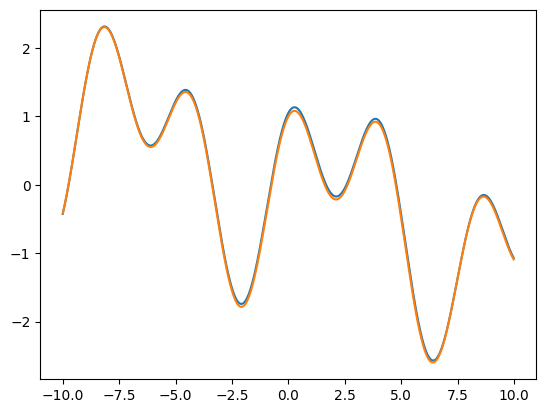

In [55]:
draw_exact(PINN)

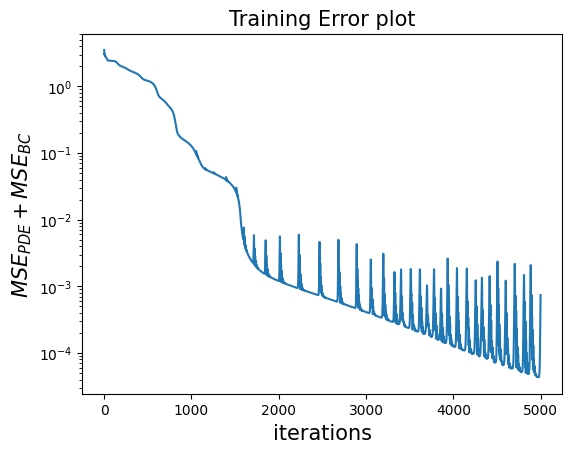

In [56]:
draw_Terror(PINN)    

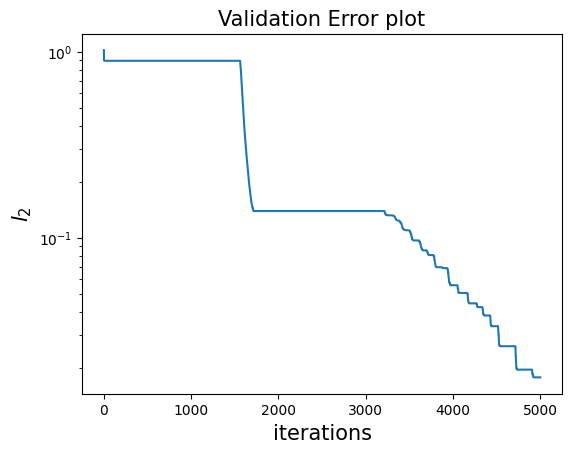

In [57]:
draw_Verror(PINN) 

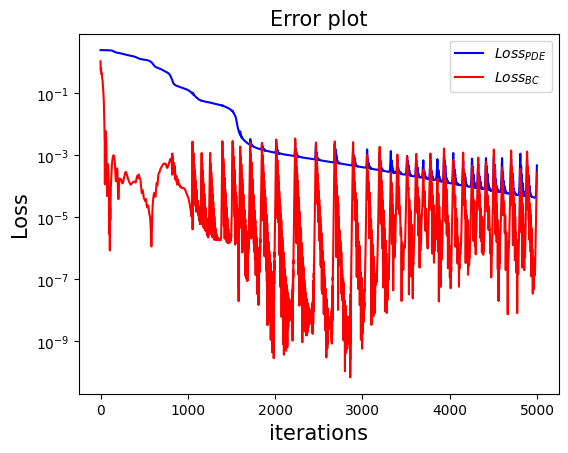

In [58]:
draw_epoch_loss(PINN)

# lbPINN

In [29]:
net = Net(layers)
# net = Net()
net = net.to(device)

model_type = 1 # 0:PINN  1:lbPINN

lbPINN = Model(
    net=net, iterations = iterations, f=f, x_bc=x_bc, u_bc=u_bc , x_test=x_test, x_test_exact=x_test_exact, model_type=model_type)

In [30]:
count_parameters(net)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| linear.0.weight |     50     |
|  linear.0.bias  |     50     |
| linear.1.weight |    2500    |
|  linear.1.bias  |     50     |
| linear.2.weight |    2500    |
|  linear.2.bias  |     50     |
| linear.3.weight |     50     |
|  linear.3.bias  |     1      |
+-----------------+------------+
Total Trainable Params: 5251


5251

In [31]:
lbPINN.train()

100%|█████| 5000/5000 [00:34<00:00, 142.94it/s, Iter=4999, Loss=6.37e-03, PDE=6.36e-03, BC=1.15e-05]

Training time: 34.98


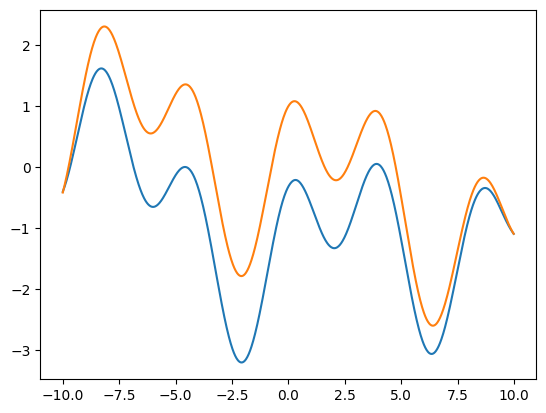

In [32]:
draw_exact(lbPINN)

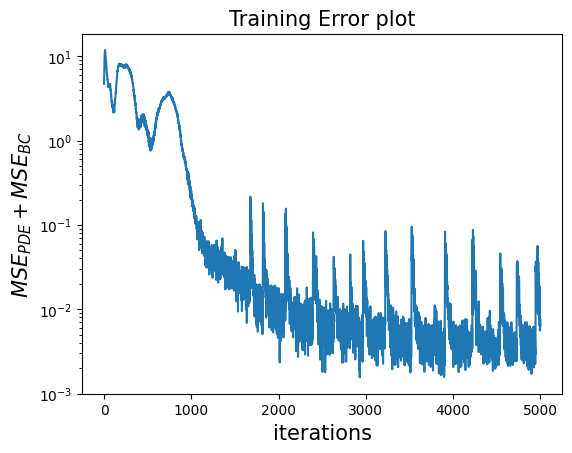

In [33]:
draw_Terror(lbPINN)

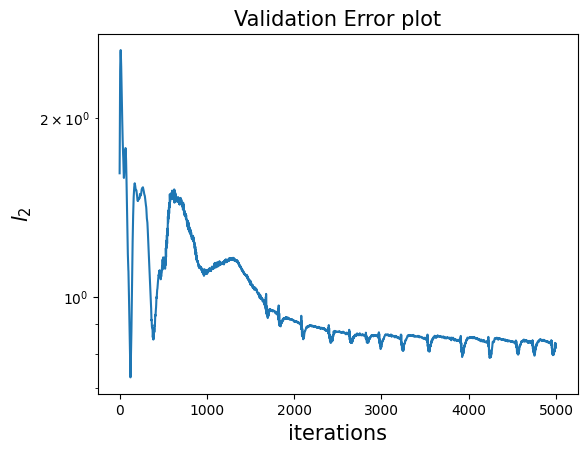

In [34]:
draw_Verror(lbPINN)

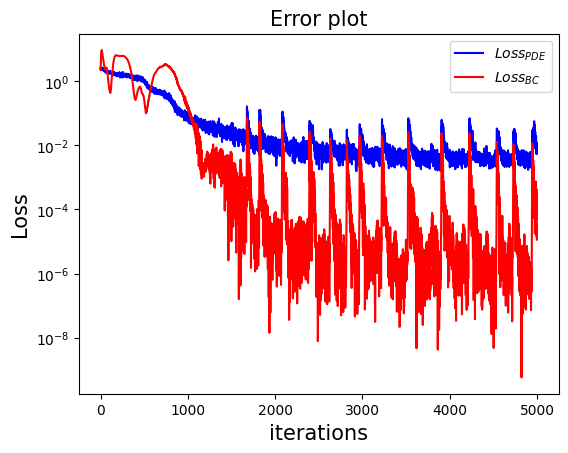

In [35]:
draw_epoch_loss(lbPINN)

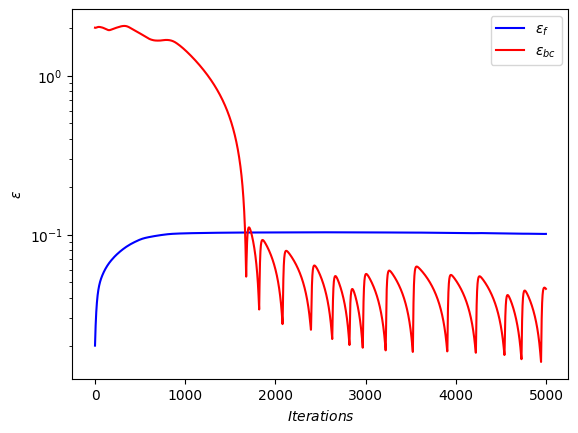

In [36]:
draw_epoch_e(lbPINN)

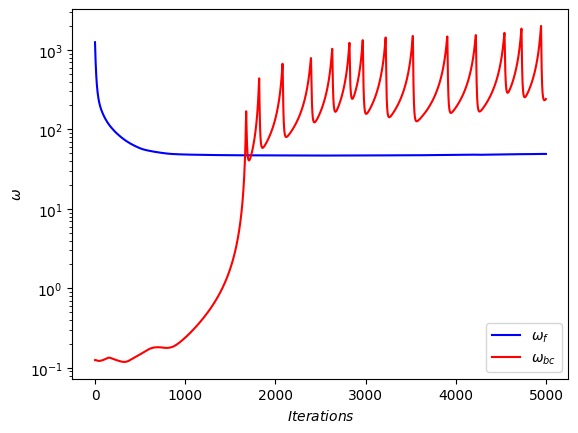

In [37]:
draw_epoch_w(lbPINN)